In [33]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Layer, Bidirectional
import tensorflow as tf
import time

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
df = pd.read_csv('/content/drive/MyDrive/PLN_Timeseries/442100118673_hourly_meteostat.csv')
df['READ_DATE'] = pd.to_datetime(df['READ_DATE'])
# df.drop('READ_DATE_day', axis=1, inplace=True)
df.set_index('READ_DATE', inplace=True)
df

KWH_EXP  temp  dwpt  rhum   wdir  wspd    pres  coco
READ_DATE                                                                   
2019-01-01 00:00:00   81.827423  26.1  25.2  95.0  140.0   5.4  1010.0   7.0
2019-01-01 01:00:00   81.335048  27.7  24.7  84.0  321.0   5.5  1009.8   7.0
2019-01-01 02:00:00   81.252447  28.7  24.7  79.0  329.0   7.4  1009.7   7.0
2019-01-01 03:00:00   81.323956  25.4  24.9  97.0  323.0   0.0  1010.1   7.0
2019-01-01 04:00:00   81.340817  29.5  25.0  77.0  327.0  11.1  1008.9   8.0
...                         ...   ...   ...   ...    ...   ...     ...   ...
2024-05-31 19:00:00  108.370055  28.2  23.1  74.0  150.0   9.4  1011.6   2.0
2024-05-31 20:00:00  109.709303  28.2  23.1  74.0  150.0   9.4  1011.6   2.0
2024-05-31 21:00:00  110.409656  28.2  23.1  74.0  150.0   9.4  1011.6   2.0
2024-05-31 22:00:00  112.180675  28.2  23.1  74.0  150.0   9.4  1011.6   2.0
2024-05-31 23:00:00  112.205362  28.2  23.1  74.0  150.0   9.4  1011.6   2.0

[47472 rows x 8 columns]

In [36]:
# split data train dan test. 3 tahun pertama untuk train, 2 tahun terakhir untuk test
train = df.loc['2019-01-01':'2022-12-31']
test = df.loc['2023-01-01':]

In [37]:
# Create separate scalers for features and target
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

train_scaled_features = feature_scaler.fit_transform(train)
train_scaled_features = pd.DataFrame(train_scaled_features, columns=train.columns, index=train.index)

test_scaled_features = feature_scaler.transform(test)
test_scaled_features = pd.DataFrame(test_scaled_features, columns=test.columns, index=test.index)

train_scaled_target = target_scaler.fit_transform(train[['KWH_EXP']])
test_scaled_target = target_scaler.transform(test[['KWH_EXP']])


In [38]:
train_scaled_features

KWH_EXP      temp      dwpt      rhum      wdir  \
READ_DATE                                                               
2019-01-01 00:00:00  0.664735 -0.466364  1.185728  1.343937 -0.420074   
2019-01-01 01:00:00  0.650839  0.074062  0.935136  0.514419  1.720327   
2019-01-01 02:00:00  0.648508  0.411829  0.935136  0.137365  1.814930   
2019-01-01 03:00:00  0.650526 -0.702801  1.035373  1.494759  1.743978   
2019-01-01 04:00:00  0.651002  0.682042  1.085491 -0.013457  1.791279   
...                       ...       ...       ...       ...       ...   
2022-12-31 19:00:00 -1.240539 -0.702801  0.584308  1.117705  1.377390   
2022-12-31 20:00:00 -1.243250 -0.669024  0.534190  1.042294  1.436517   
2022-12-31 21:00:00 -1.267635 -0.229928  0.634426  0.589829  1.590247   
2022-12-31 22:00:00 -1.271561 -0.500141  0.684544  0.966883  1.483818   
2022-12-31 23:00:00 -1.273226 -0.365034  0.734663  0.816062  1.460168   

                         wspd      pres      coco  
READ_DATE                                          
2019-01-01 00:00:00 -0.741796  0.370252  0.708480  
2019-01-01 01:00:00 -0.720198  0.268182  0.708480  
2019-01-01 02:00:00 -0.309831  0.217147  0.708480  
2019-01-01 03:00:00 -1.908102  0.421287  0.708480  
2019-01-01 04:00:00  0.489305 -0.191132  0.927251  
...                       ...       ...       ...  
2022-12-31 19:00:00  0.899672 -0.956655  1.146022  
2022-12-31 20:00:00  0.899672 -1.007690  1.146022  
2022-12-31 21:00:00  2.519541 -0.650446  0.927251  
2022-12-31 22:00:00  2.497943 -0.701481  0.708480  
2022-12-31 23:00:00  1.698808 -0.446306  0.708480  

[35064 rows x 8 columns]

In [39]:
# Update plot_predictions function
def plot_predictions(model, X_test_t, y_test_t, scaler, timesteps, n_future=48):
    # Make predictions
    y_pred = model.predict(X_test_t)
    # Inverse transform predictions and actual values using target_scaler
    y_test_orig = target_scaler.inverse_transform(y_test_t.reshape(-1, 1))
    y_pred_orig = target_scaler.inverse_transform(y_pred)

    # Create plots
    plt.figure(figsize=(15, 6))

    # Actual vs Predicted
    plt.subplot(1, 2, 1)
    plt.plot(y_test_orig, label='Actual', alpha=0.8)
    plt.plot(y_pred_orig, label='Predicted', alpha=0.8)
    plt.title(f'Actual vs Predicted (Timesteps={timesteps})')
    plt.xlabel('Time')
    plt.ylabel('KWH_EXP')
    plt.legend()
    plt.grid(True)

    # Future Predictions
    last_sequence = X_test_t[-1:]
    future_pred = []

    for _ in range(n_future):
        next_pred = model.predict(last_sequence)
        future_pred.append(next_pred[0])

        last_sequence = np.roll(last_sequence, -1, axis=1)
        last_sequence[0, -1] = next_pred[0]

    future_pred = target_scaler.inverse_transform(np.array(future_pred).reshape(-1, 1))

    plt.subplot(1, 2, 2)
    plt.plot(range(100), y_test_orig[-100:], label='Historical', alpha=0.8)
    plt.plot(range(99, 99 + n_future), future_pred, label='Future Predictions', alpha=0.8)
    plt.title(f'Future Predictions (Next {n_future} hours)')
    plt.xlabel('Time')
    plt.ylabel('KWH_EXP')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Print metrics
    mse = mean_squared_error(y_test_orig, y_pred_orig)
    r2 = r2_score(y_test_orig, y_pred_orig)
    mape = mean_absolute_percentage_error(y_test_orig, y_pred_orig)
    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    print(f"\nMetrics for timesteps={timesteps}:")
    print(f"MSE: {mse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"MAE: {mae:.4f}")

def train_and_plot_bilstm(X_train, y_train, X_test, y_test, timesteps):
    def create_dataset(X, y, time_steps=1):
        Xs, ys = [], []
        for i in range(len(X) - time_steps):
            v = X.iloc[i:(i + time_steps)].values
            Xs.append(v)
            ys.append(y[i + time_steps])
        return np.array(Xs), np.array(ys)

    X_train_t, y_train_t = create_dataset(X_train, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test, y_test, timesteps)

    model = Sequential([
        Input(shape=(timesteps, X_train.shape[1])),
        Bidirectional(LSTM(128, return_sequences=True)),
        Bidirectional(LSTM(64)),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        mode='min',
        verbose=1
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.001,
        verbose=1
    )


    model.fit(
        X_train_t,
        y_train_t,
        validation_split=0.1,
        epochs=50,
        batch_size=512,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    plot_predictions(model, X_test_t, y_test_t, target_scaler, timesteps)

In [40]:
# Daftar timestep yang akan diuji
timesteps = [12, 24, 48, 72, 96, 168]  # 12 jam, 1 hari, 2 hari, 3 hari, 4 hari, 1 minggu



Training model with timesteps = 12
Epoch 17: early stopping
388/388 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

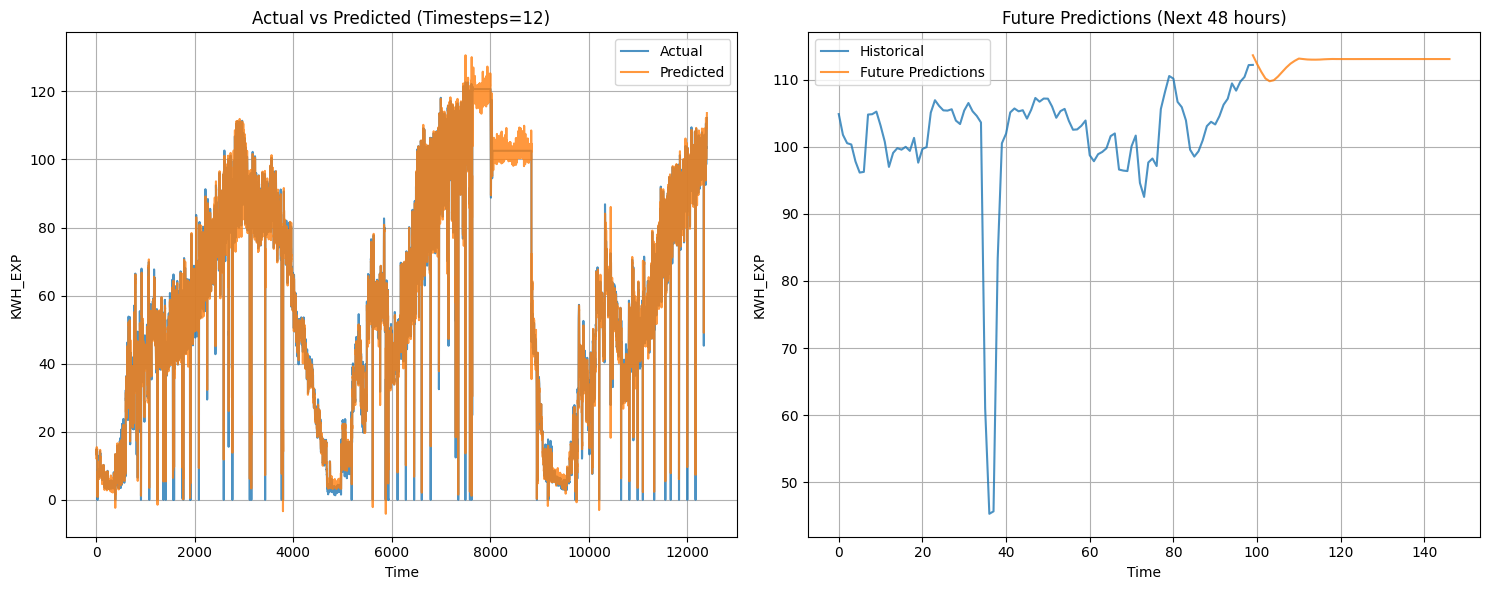


Metrics for timesteps=12:
MSE: 27.9267
R²: 0.9753
MAPE: 611940755512744.2500
MAE: 2.4818
Training time for timesteps = 12: 19.32 seconds

Training model with timesteps = 24
Epoch 20: early stopping
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

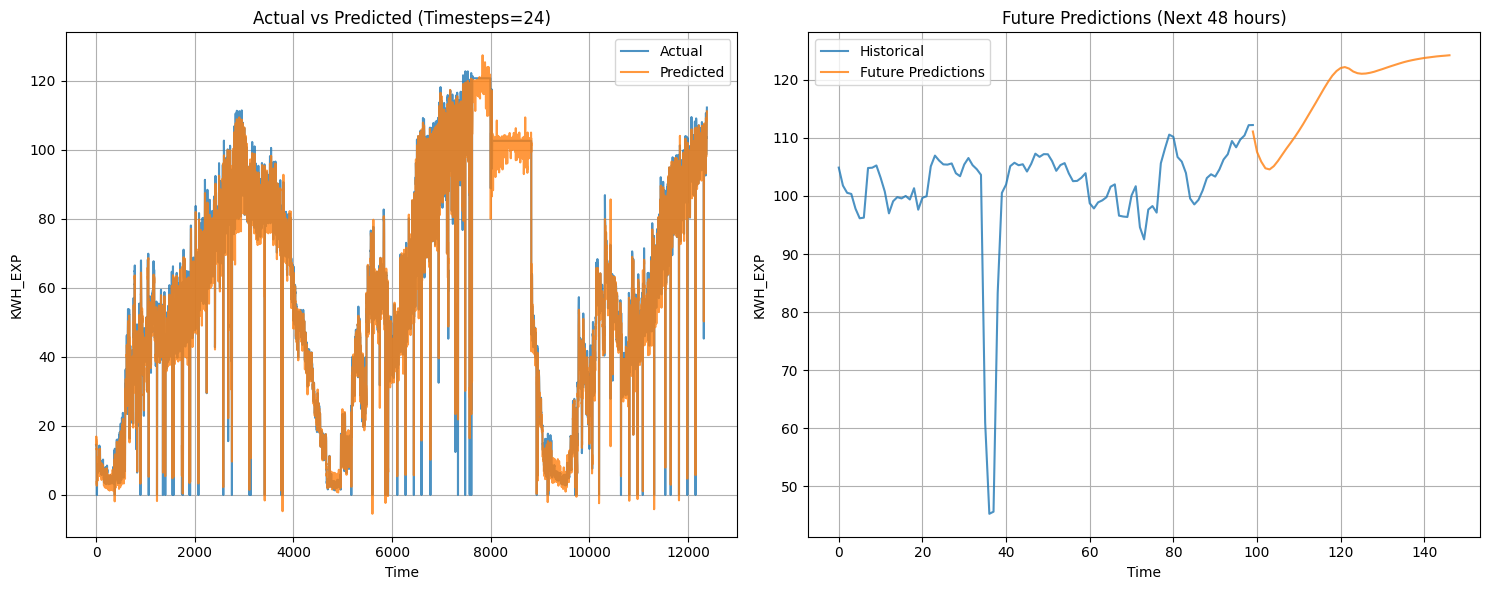


Metrics for timesteps=24:
MSE: 28.5624
R²: 0.9747
MAPE: 568213543312117.1250
MAE: 2.6628
Training time for timesteps = 24: 25.53 seconds

Training model with timesteps = 48
Epoch 22: early stopping
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


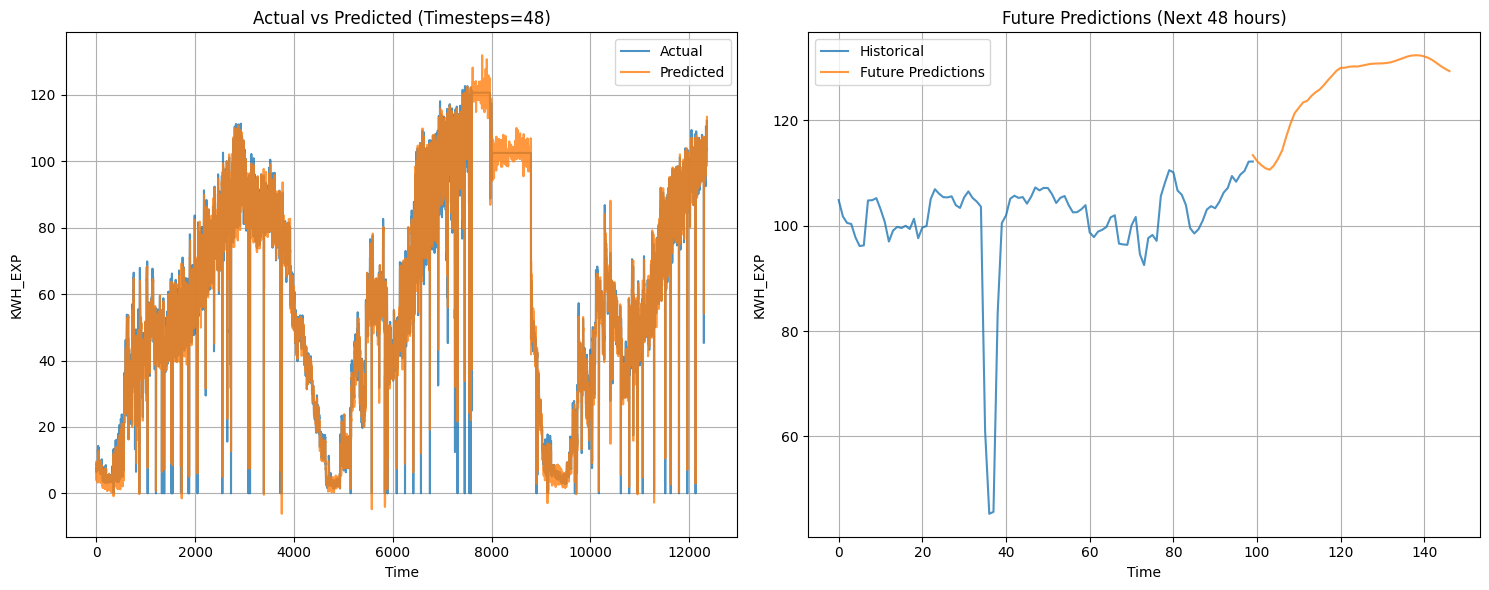


Metrics for timesteps=48:
MSE: 28.3186
R²: 0.9749
MAPE: 618407531585870.5000
MAE: 2.5366
Training time for timesteps = 48: 37.14 seconds

Training model with timesteps = 72
Epoch 16: early stopping
386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


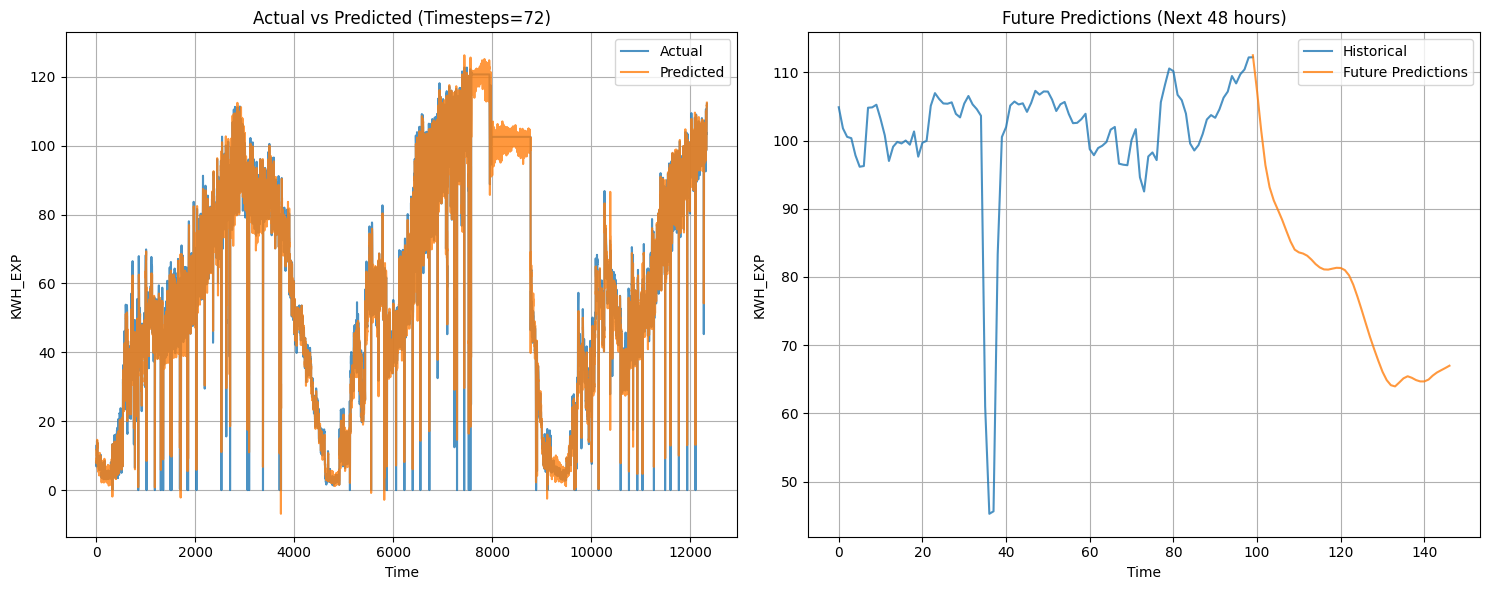


Metrics for timesteps=72:
MSE: 28.5346
R²: 0.9746
MAPE: 702910094454141.5000
MAE: 2.6871
Training time for timesteps = 72: 39.35 seconds

Training model with timesteps = 96
Epoch 23: early stopping
385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


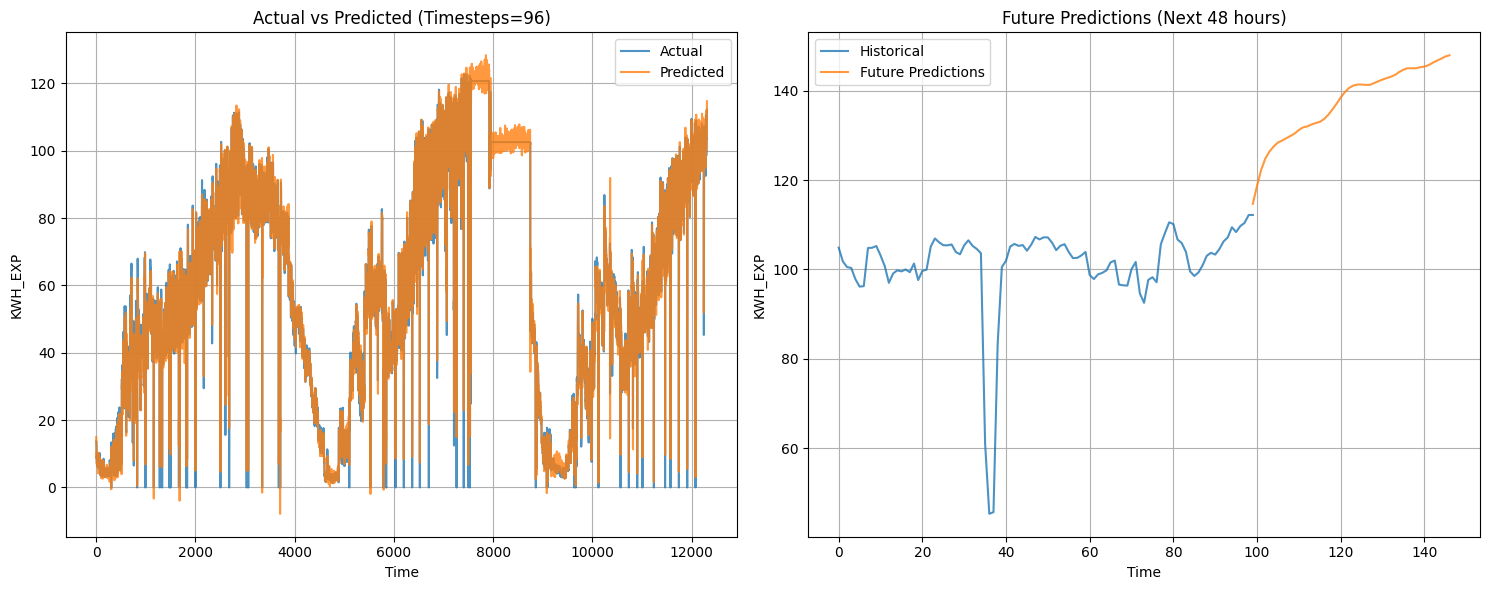


Metrics for timesteps=96:
MSE: 27.5621
R²: 0.9754
MAPE: 634441979500340.7500
MAE: 2.5205
Training time for timesteps = 96: 64.66 seconds

Training model with timesteps = 168
Epoch 23: early stopping
383/383 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/ste

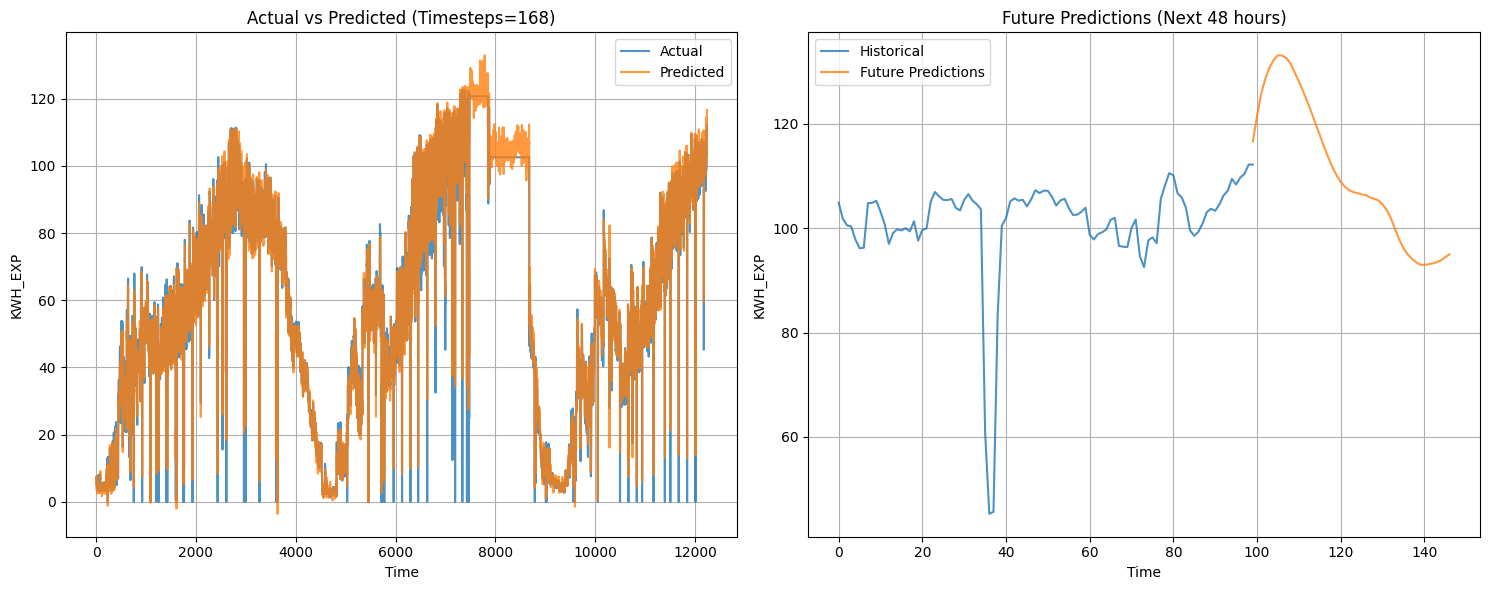


Metrics for timesteps=168:
MSE: 31.1907
R²: 0.9719
MAPE: 742597643956765.2500
MAE: 2.9019
Training time for timesteps = 168: 103.40 seconds


In [41]:
for ts in timesteps:
    start_time = time.time()
    print(f"\nTraining model with timesteps = {ts}")
    train_and_plot_bilstm(train_scaled_features, train_scaled_target.ravel(),
                         test_scaled_features, test_scaled_target.ravel(), ts)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time for timesteps = {ts}: {training_time:.2f} seconds")

In [42]:
# Update training functions to use scaled features and target
def train_and_plot_lstm(X_train, y_train, X_test, y_test, timesteps):
    def create_dataset(X, y, time_steps=1):
        Xs, ys = [], []
        for i in range(len(X) - time_steps):
            v = X.iloc[i:(i + time_steps)].values
            Xs.append(v)
            ys.append(y[i + time_steps])
        return np.array(Xs), np.array(ys)

    X_train_t, y_train_t = create_dataset(X_train, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test, y_test, timesteps)

    model = Sequential([
        Input(shape=(timesteps, X_train.shape[1])),
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        mode='min',
        verbose=1
    )

    model.fit(
        X_train_t,
        y_train_t,
        validation_split=0.1,
        epochs=50,
        batch_size=512,
        callbacks=[early_stopping],
        verbose=0
    )

    plot_predictions(model, X_test_t, y_test_t, target_scaler, timesteps)


Training model with timesteps = 12
Epoch 13: early stopping
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

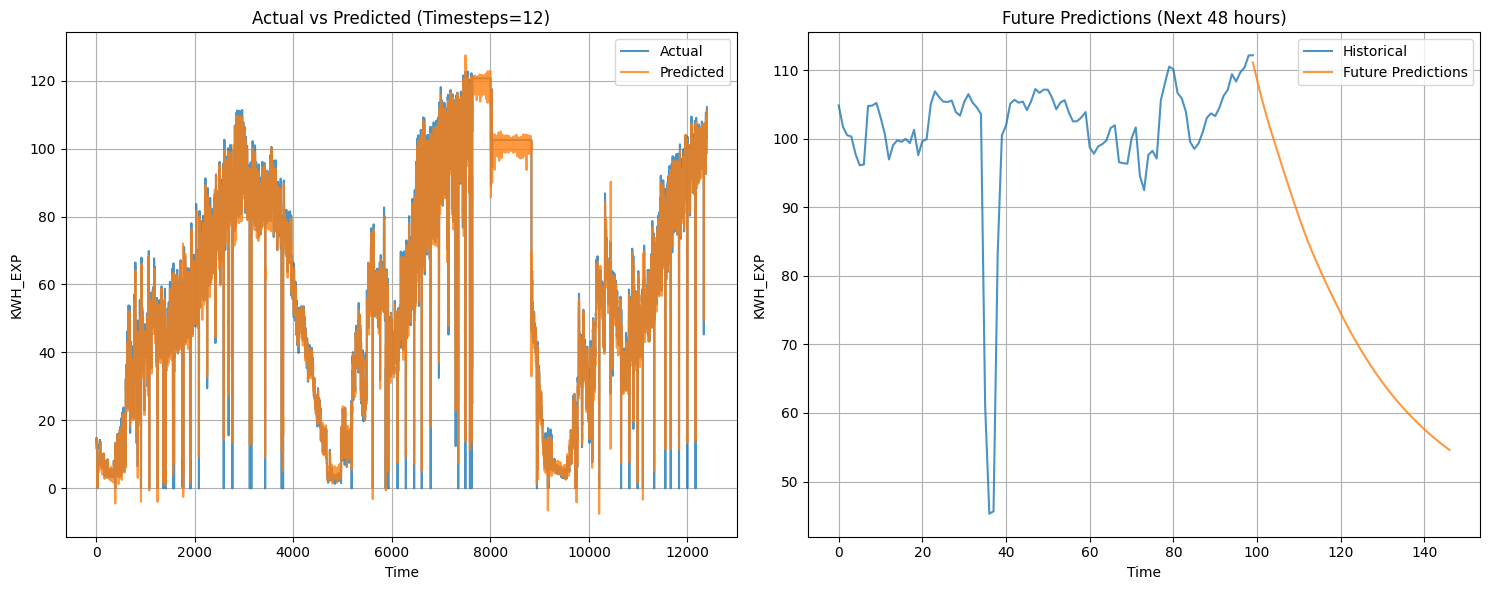


Metrics for timesteps=12:
MSE: 28.8207
R²: 0.9745
MAPE: 638161383816825.1250
MAE: 2.6164
Training time for timesteps = 12: 12.44 seconds

Training model with timesteps = 24
Epoch 11: early stopping
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

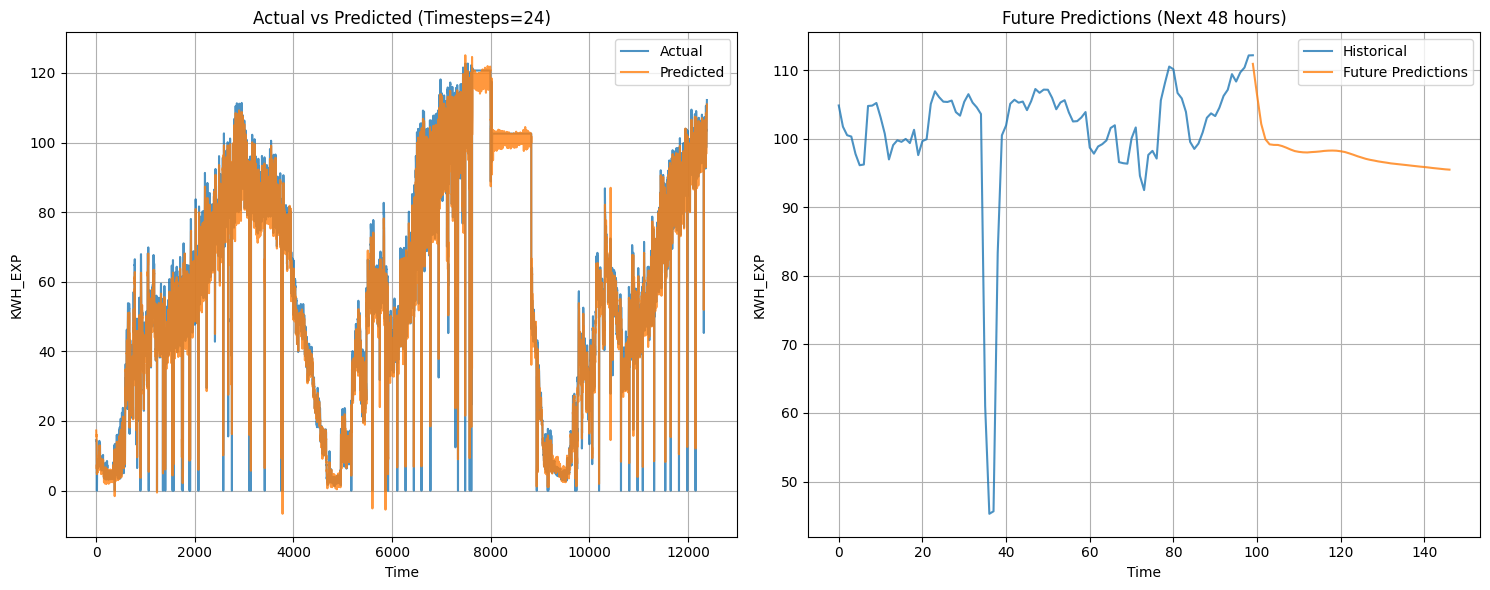


Metrics for timesteps=24:
MSE: 29.1439
R²: 0.9742
MAPE: 656277013754142.1250
MAE: 2.7838
Training time for timesteps = 24: 12.46 seconds

Training model with timesteps = 48
Epoch 14: early stopping
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


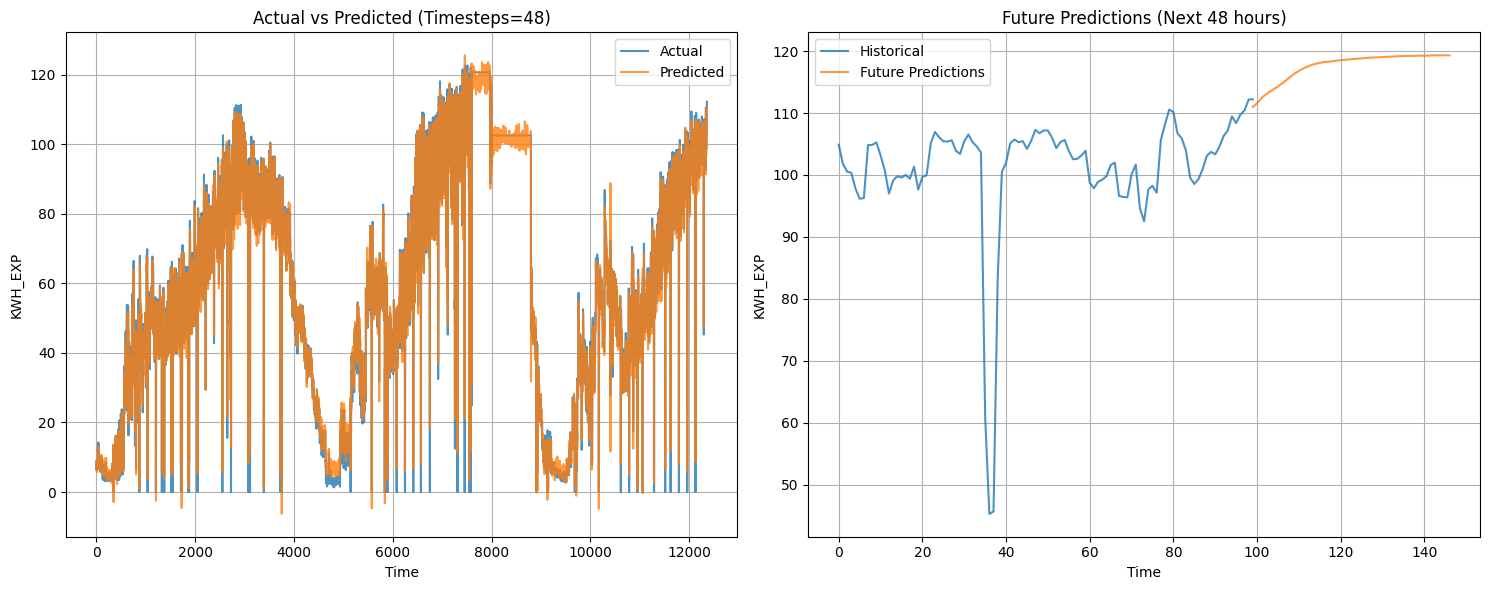


Metrics for timesteps=48:
MSE: 28.2743
R²: 0.9749
MAPE: 600251881145815.6250
MAE: 2.6184
Training time for timesteps = 48: 16.16 seconds

Training model with timesteps = 72
Epoch 10: early stopping
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


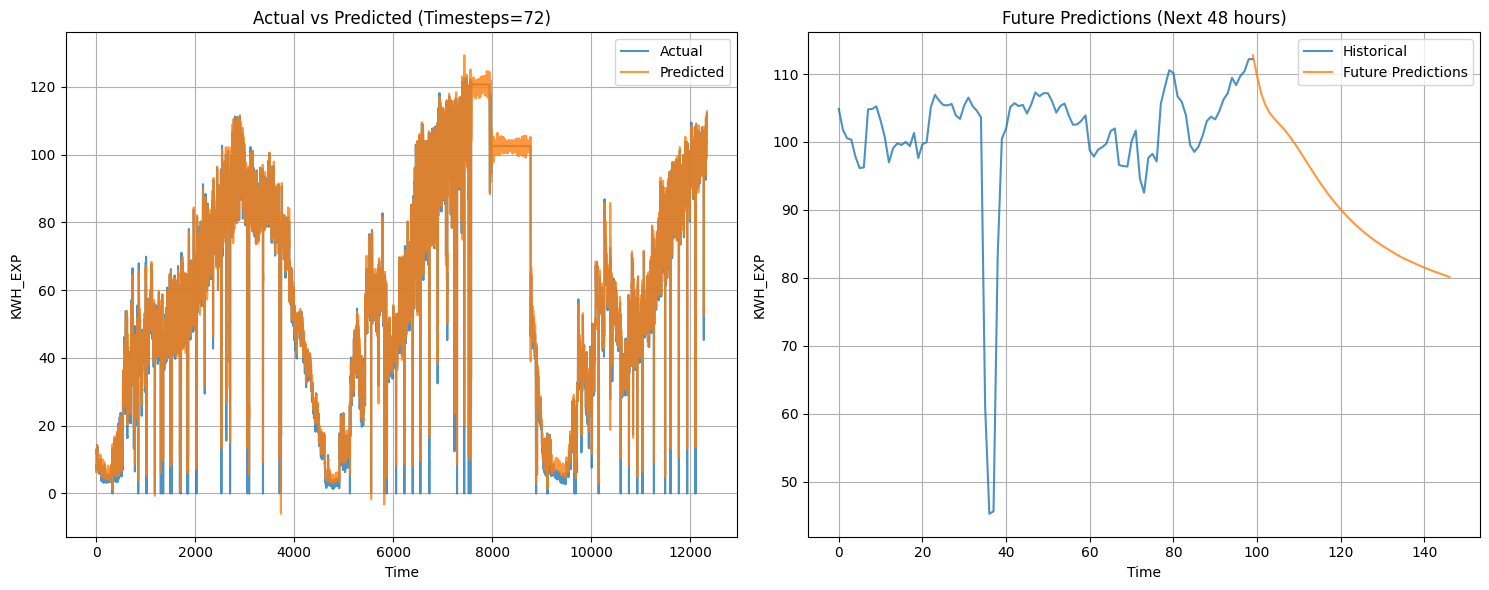


Metrics for timesteps=72:
MSE: 28.4617
R²: 0.9747
MAPE: 671893581468992.3750
MAE: 2.4873
Training time for timesteps = 72: 16.32 seconds

Training model with timesteps = 96
Epoch 10: early stopping
385/385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


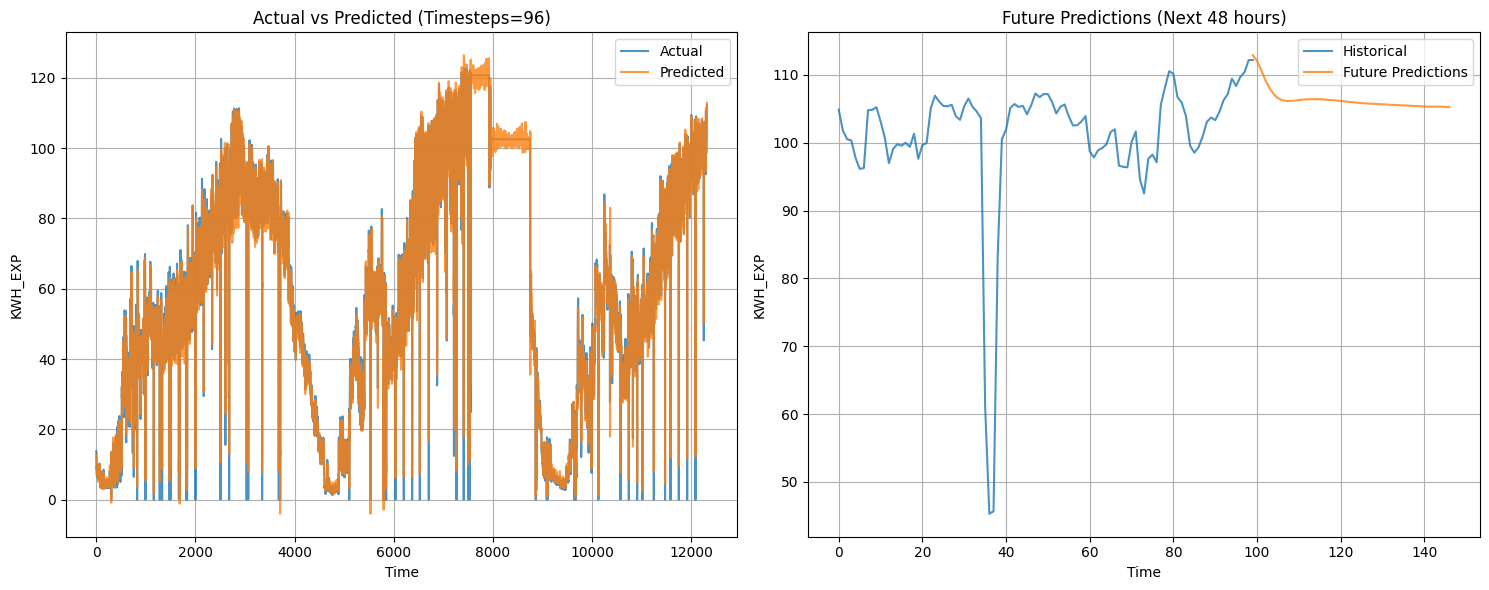


Metrics for timesteps=96:
MSE: 28.3297
R²: 0.9747
MAPE: 607693728160179.5000
MAE: 2.4205
Training time for timesteps = 96: 18.77 seconds

Training model with timesteps = 168
Epoch 8: early stopping
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


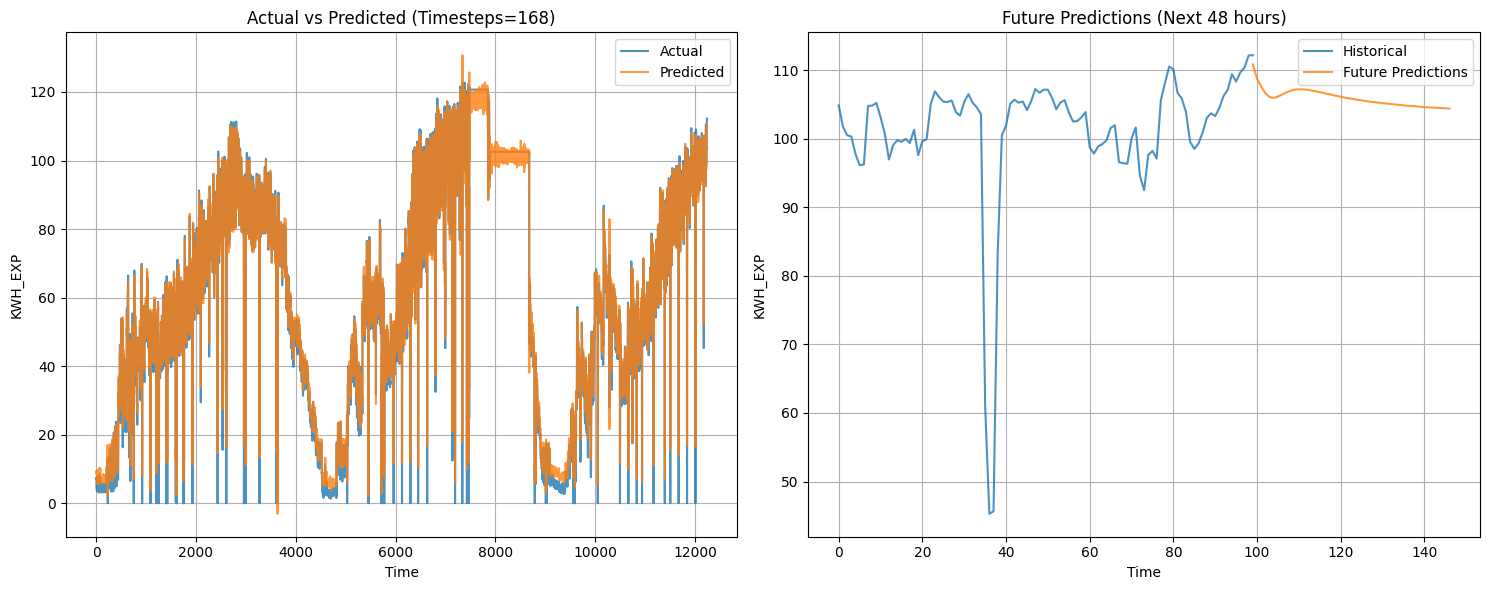


Metrics for timesteps=168:
MSE: 30.0790
R²: 0.9729
MAPE: 731962352600068.3750
MAE: 2.7641
Training time for timesteps = 168: 24.17 seconds


In [43]:
# Daftar timestep yang akan diuji
timesteps = [12, 24, 48, 72, 96, 168]  # 12 jam, 1 hari, 2 hari, 3 hari, 4 hari, 1 minggu

for ts in timesteps:
    start_time = time.time()
    print(f"\nTraining model with timesteps = {ts}")
    train_and_plot_lstm(train_scaled_features, train_scaled_target.ravel(),
                         test_scaled_features, test_scaled_target.ravel(), ts)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time for timesteps = {ts}: {training_time:.2f} seconds")


Training Attention Model with timesteps = 12
Epoch 22: early stopping
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━

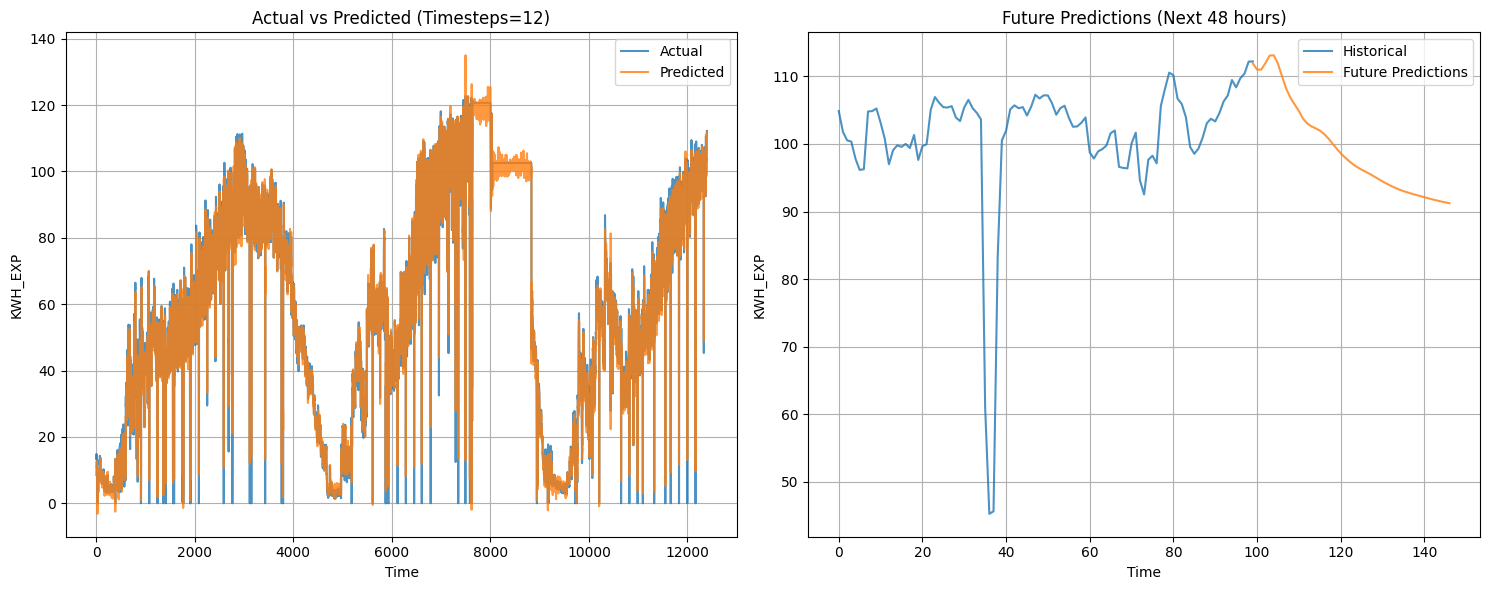


Metrics for timesteps=12:
MSE: 29.6902
R²: 0.9737
MAPE: 664615636505915.2500
MAE: 2.7171
Training time for timesteps = 12: 14.79 seconds

Training Attention Model with timesteps = 24
Epoch 23: early stopping
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

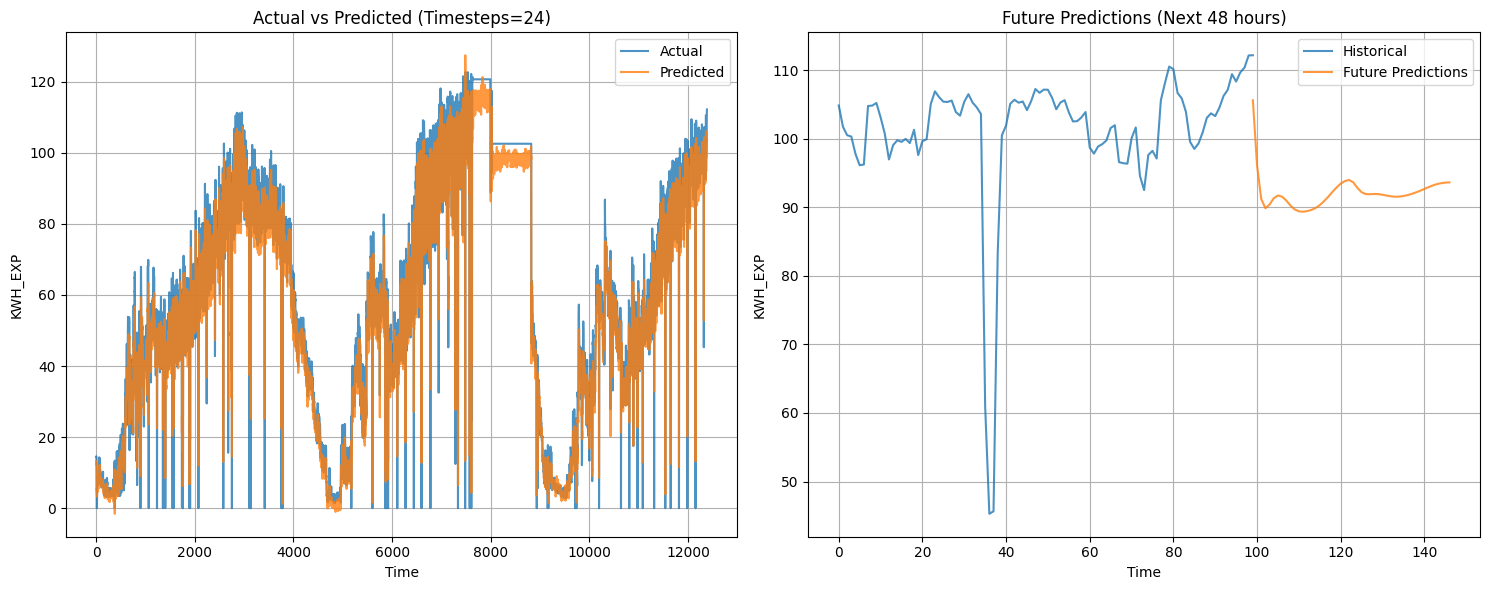


Metrics for timesteps=24:
MSE: 40.3536
R²: 0.9643
MAPE: 873791572720605.8750
MAE: 4.2073
Training time for timesteps = 24: 17.95 seconds

Training Attention Model with timesteps = 48
Epoch 27: early stopping
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

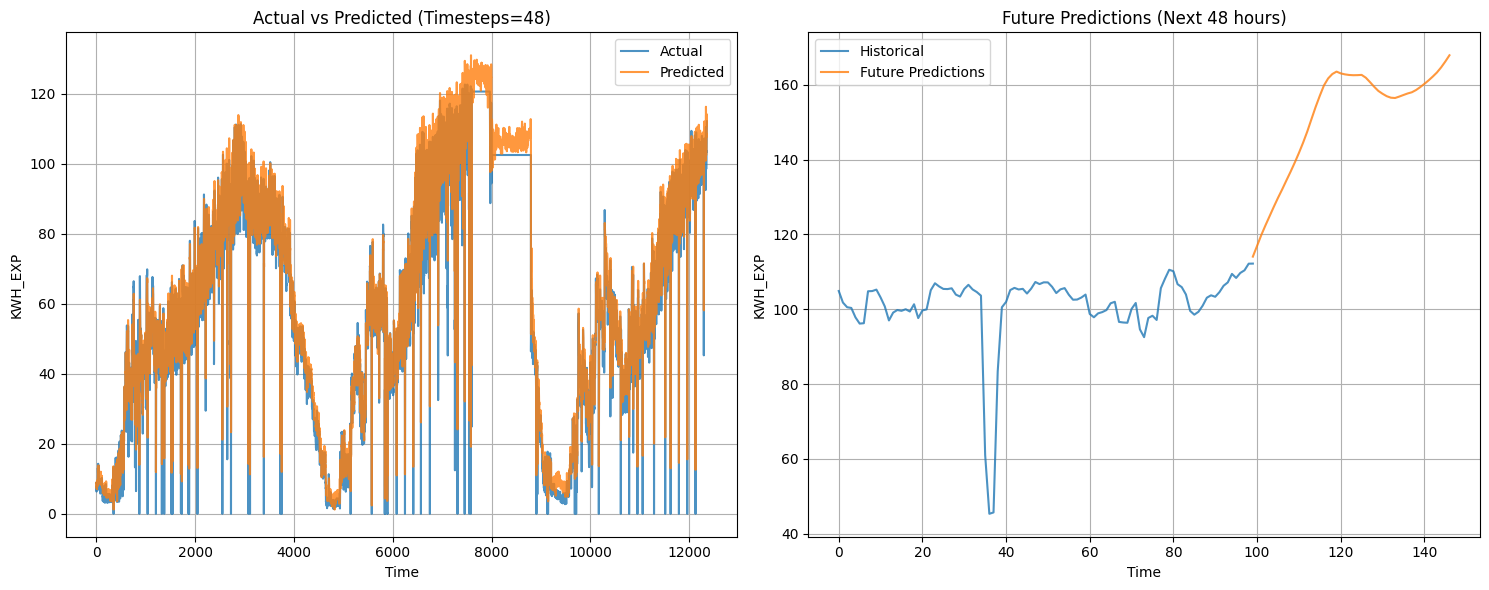


Metrics for timesteps=48:
MSE: 42.0364
R²: 0.9627
MAPE: 892310234909562.0000
MAE: 3.9852
Training time for timesteps = 48: 20.24 seconds

Training Attention Model with timesteps = 72
Epoch 23: early stopping
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

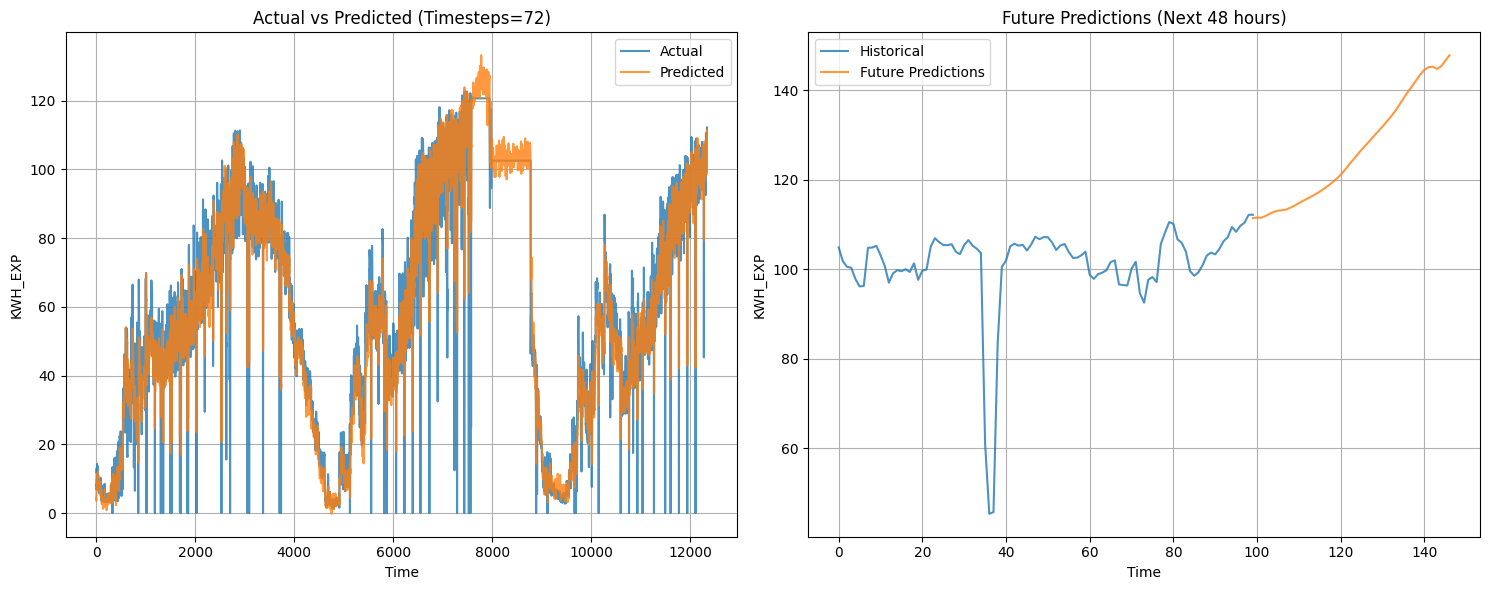


Metrics for timesteps=72:
MSE: 67.5974
R²: 0.9398
MAPE: 1541085676591187.0000
MAE: 4.8729
Training time for timesteps = 72: 21.61 seconds

Training Attention Model with timesteps = 96
Epoch 9: early stopping
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

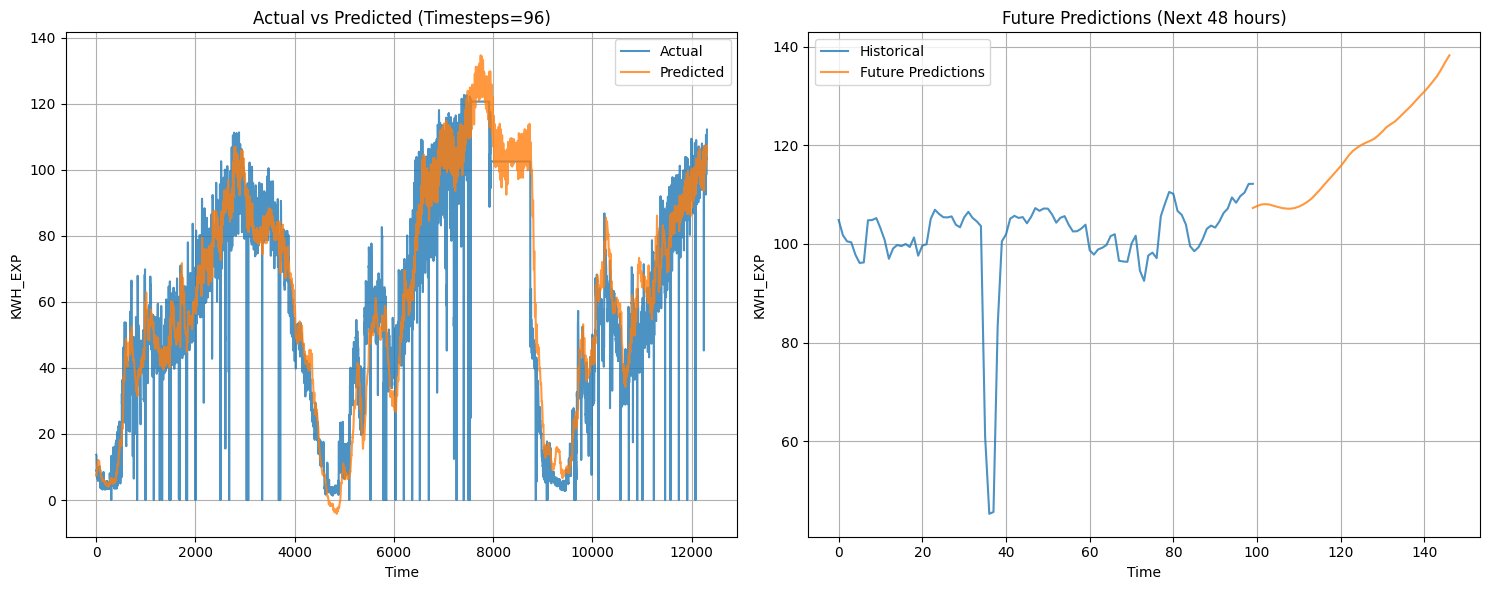


Metrics for timesteps=96:
MSE: 149.0283
R²: 0.8670
MAPE: 2124942568446569.2500
MAE: 8.0207
Training time for timesteps = 96: 15.23 seconds

Training Attention Model with timesteps = 168
Epoch 5: early stopping
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

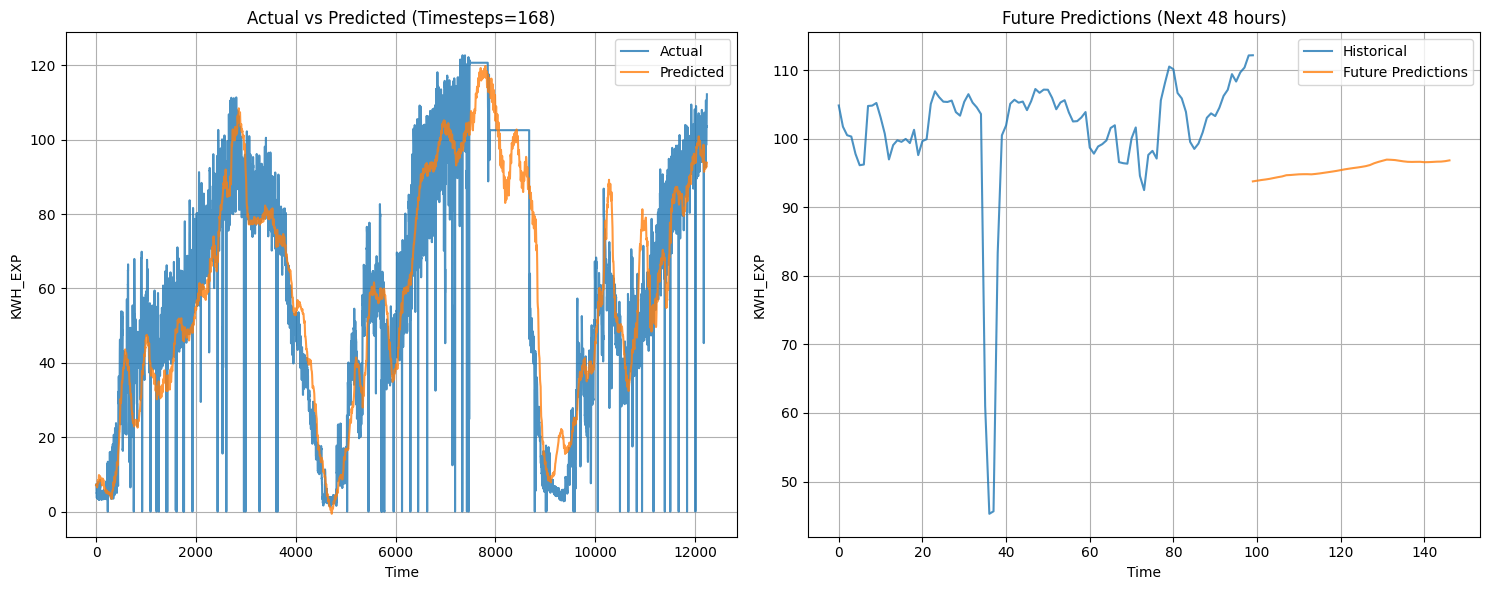


Metrics for timesteps=168:
MSE: 198.3009
R²: 0.8216
MAPE: 2048907437319505.2500
MAE: 10.3057
Training time for timesteps = 168: 15.28 seconds


In [44]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

# Custom Attention Layer
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(1,),
                                 initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)  # Calculating scores
        a = K.softmax(e, axis=1)              # Calculating attention weights
        output = x * a                        # Applying weights to the input
        return K.sum(output, axis=1)          # Summing the weighted values

# Train and Plot Function with Attention
def train_and_plot_attention_model(X_train, y_train, X_test, y_test, timesteps):
    def create_dataset(X, y, time_steps=1):
        Xs, ys = [], []
        for i in range(len(X) - time_steps):
            v = X.iloc[i:(i + time_steps)].values
            Xs.append(v)
            ys.append(y[i + time_steps])
        return np.array(Xs), np.array(ys)

    X_train_t, y_train_t = create_dataset(X_train, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test, y_test, timesteps)

    model = Sequential([
        Input(shape=(timesteps, X_train.shape[1])),
        LSTM(128, return_sequences=True),
        Attention(),  # Attention mechanism
        Dense(64, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        mode='min',
        verbose=1
    )

    model.fit(
        X_train_t,
        y_train_t,
        validation_split=0.1,
        epochs=50,
        batch_size=512,
        callbacks=[early_stopping],
        verbose=0
    )

    plot_predictions(model, X_test_t, y_test_t, target_scaler, timesteps)

# Daftar timestep yang akan diuji
timesteps = [12, 24, 48, 72, 96, 168]  # 12 jam, 1 hari, 2 hari, 3 hari, 4 hari, 1 minggu

for ts in timesteps:
    start_time = time.time()
    print(f"\nTraining Attention Model with timesteps = {ts}")
    train_and_plot_attention_model(train_scaled_features, train_scaled_target.ravel(),
                                   test_scaled_features, test_scaled_target.ravel(), ts)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time for timesteps = {ts}: {training_time:.2f} seconds")


Training Attention Model with BiLSTM and timesteps = 12
Epoch 28: early stopping
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1

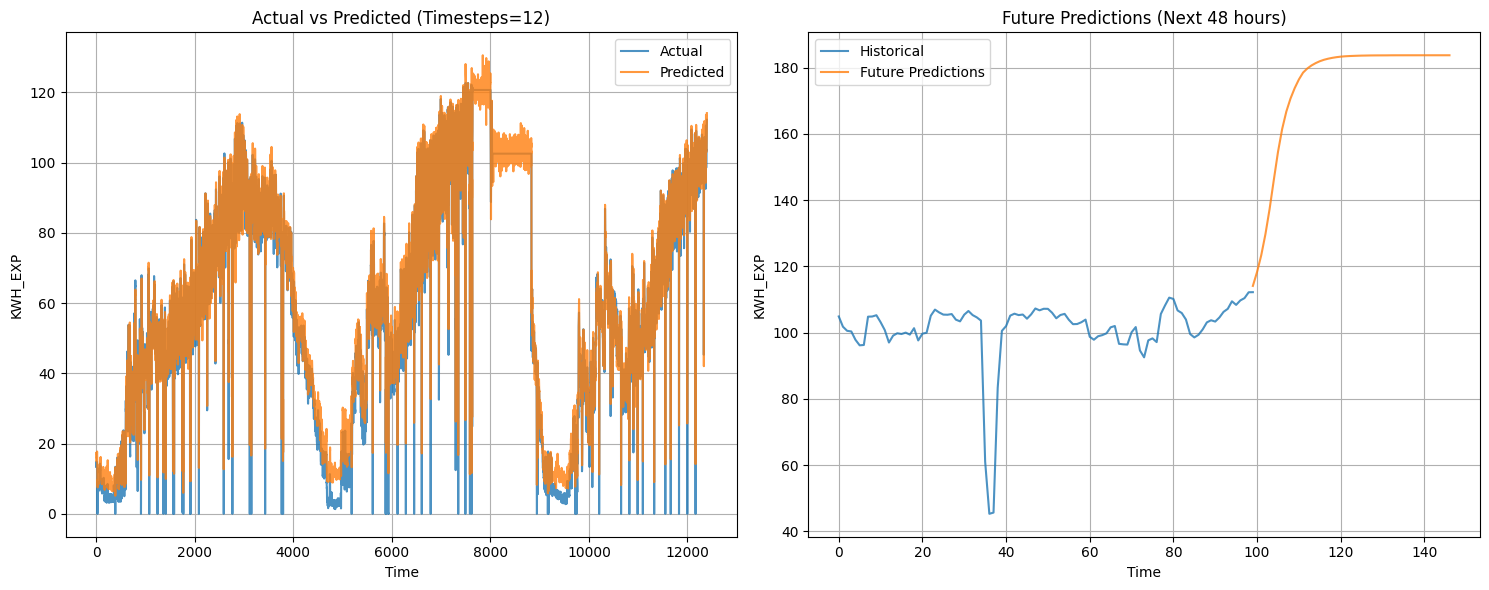


Metrics for timesteps=12:
MSE: 38.4480
R²: 0.9660
MAPE: 891353094773407.3750
MAE: 3.6969
Training time for timesteps = 12: 20.66 seconds

Training Attention Model with BiLSTM and timesteps = 24
Epoch 24: early stopping
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━

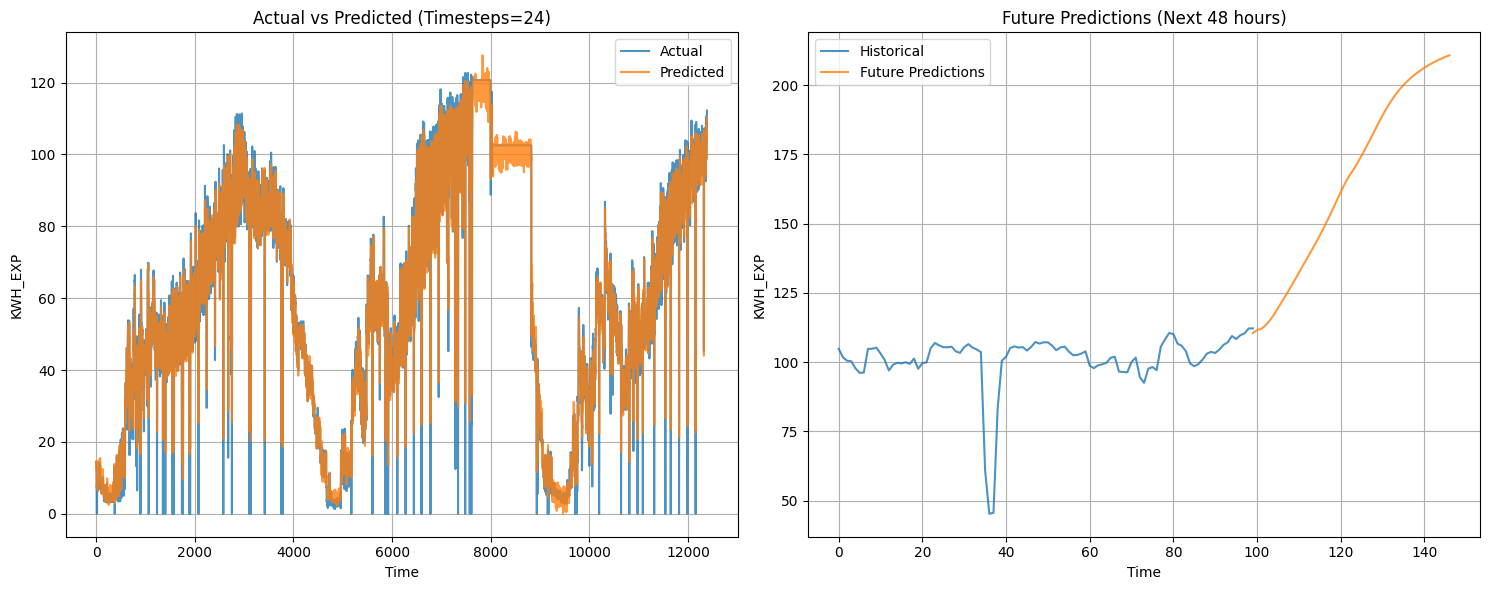


Metrics for timesteps=24:
MSE: 35.1570
R²: 0.9689
MAPE: 1036933482603745.2500
MAE: 2.9852
Training time for timesteps = 24: 20.33 seconds

Training Attention Model with BiLSTM and timesteps = 48
Epoch 24: early stopping
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━

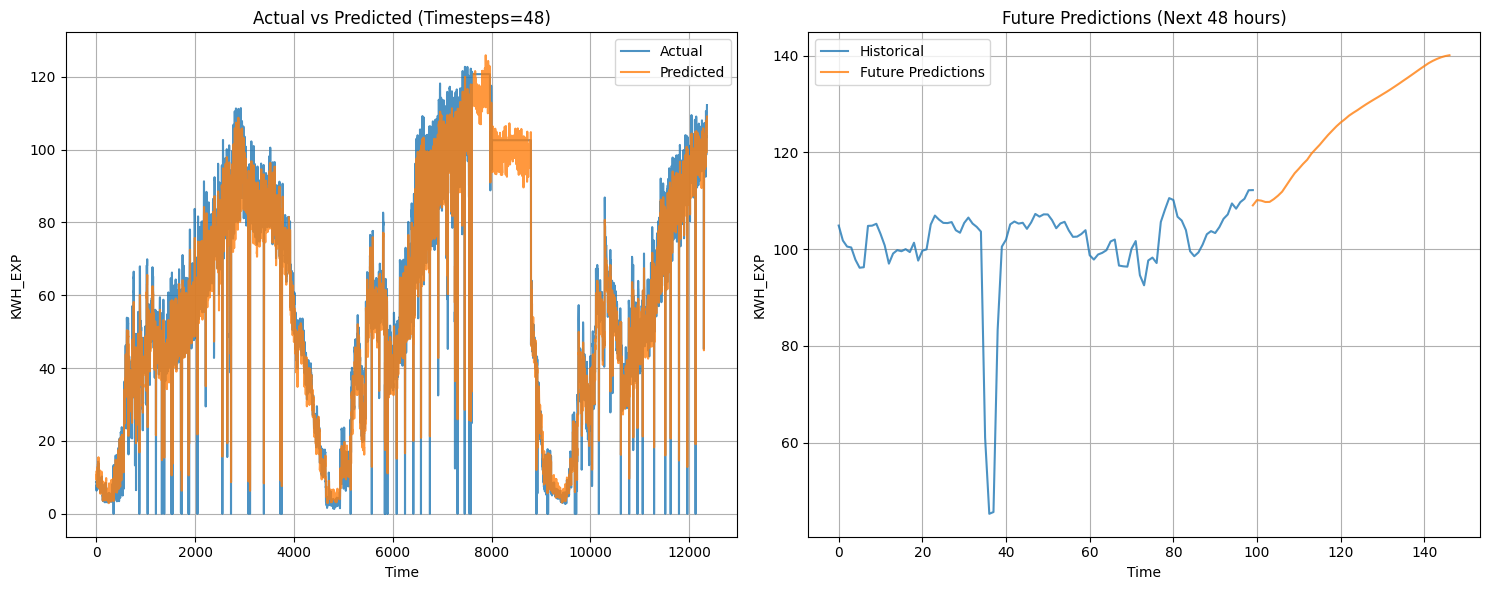


Metrics for timesteps=48:
MSE: 42.0354
R²: 0.9627
MAPE: 915326330871845.5000
MAE: 3.9657
Training time for timesteps = 48: 27.95 seconds

Training Attention Model with BiLSTM and timesteps = 72
Epoch 17: early stopping
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━

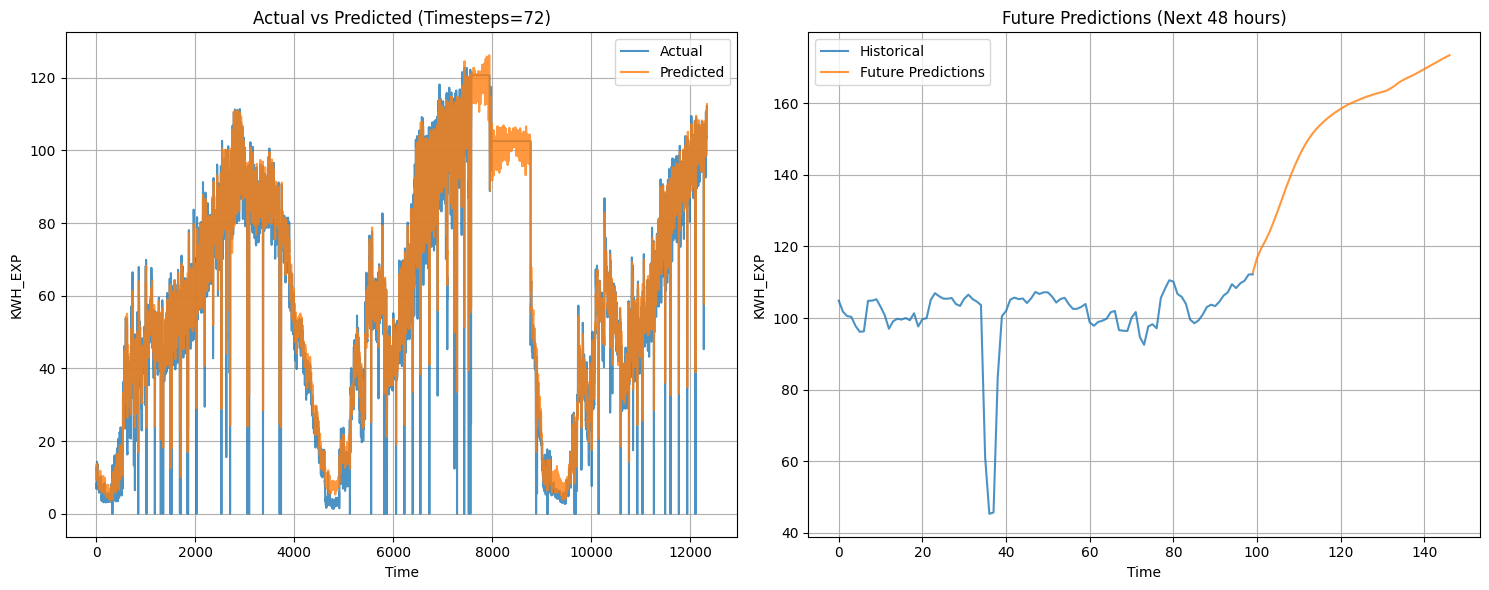


Metrics for timesteps=72:
MSE: 44.9302
R²: 0.9600
MAPE: 1278630406182697.2500
MAE: 3.6455
Training time for timesteps = 72: 28.75 seconds

Training Attention Model with BiLSTM and timesteps = 96
Epoch 24: early stopping
385/385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━

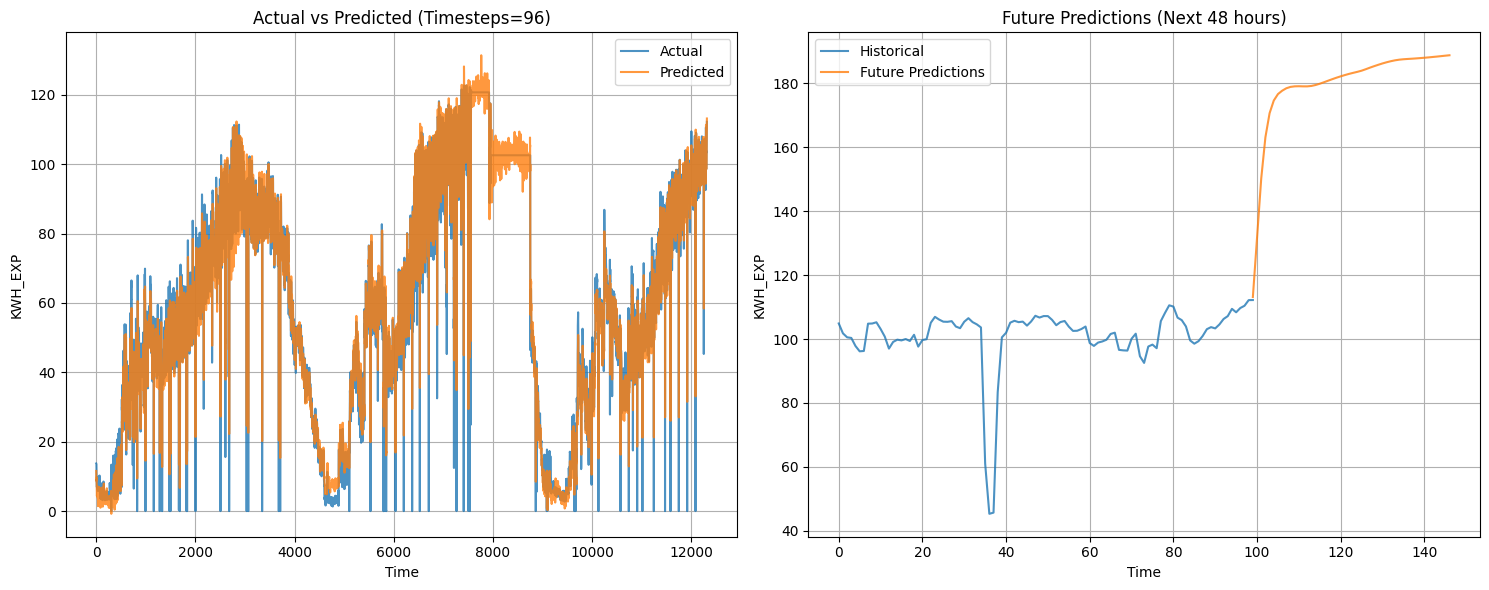


Metrics for timesteps=96:
MSE: 40.5686
R²: 0.9638
MAPE: 1077648239759948.6250
MAE: 3.4488
Training time for timesteps = 96: 45.52 seconds

Training Attention Model with BiLSTM and timesteps = 168
Epoch 26: early stopping
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━

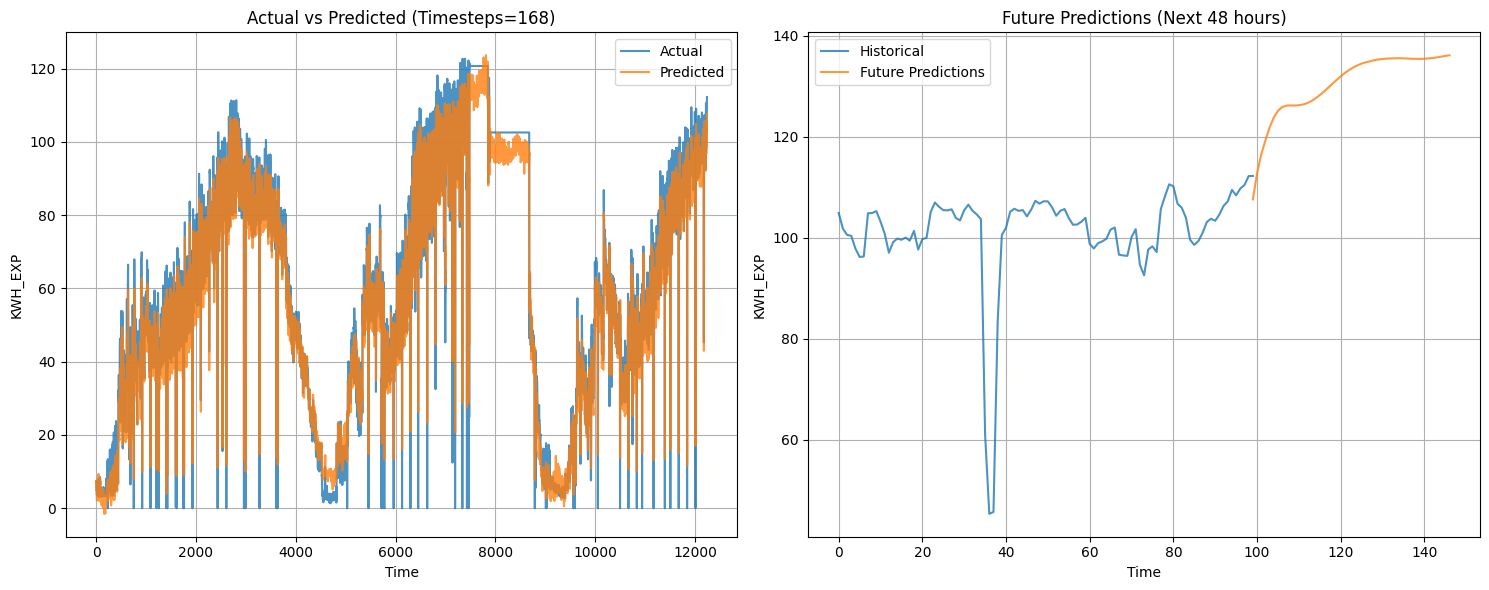


Metrics for timesteps=168:
MSE: 50.3464
R²: 0.9547
MAPE: 864491247482808.2500
MAE: 4.6732
Training time for timesteps = 168: 76.13 seconds


In [45]:
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Input
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
from tensorflow.keras import layers
import numpy as np

# Custom Attention Layer
class Attention(layers.Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(1,),
                                 initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)  # Calculating scores
        a = K.softmax(e, axis=1)              # Calculating attention weights
        output = x * a                        # Applying weights to the input
        return K.sum(output, axis=1)          # Summing the weighted values

# Train and Plot Function with Attention and BiLSTM
def train_and_plot_attention_model(X_train, y_train, X_test, y_test, timesteps):
    def create_dataset(X, y, time_steps=1):
        Xs, ys = [], []
        for i in range(len(X) - time_steps):
            v = X.iloc[i:(i + time_steps)].values
            Xs.append(v)
            ys.append(y[i + time_steps])
        return np.array(Xs), np.array(ys)

    X_train_t, y_train_t = create_dataset(X_train, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test, y_test, timesteps)

    model = Sequential([
        Input(shape=(timesteps, X_train.shape[1])),
        Bidirectional(LSTM(128, return_sequences=True)),  # Using Bidirectional LSTM
        Attention(),  # Attention mechanism
        Dense(64, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        mode='min',
        verbose=1
    )

    model.fit(
        X_train_t,
        y_train_t,
        validation_split=0.1,
        epochs=50,
        batch_size=512,
        callbacks=[early_stopping],
        verbose=0
    )

    plot_predictions(model, X_test_t, y_test_t, target_scaler, timesteps)

# Daftar timestep yang akan diuji
timesteps = [12, 24, 48, 72, 96, 168]  # 12 jam, 1 hari, 2 hari, 3 hari, 4 hari, 1 minggu

for ts in timesteps:
    start_time = time.time()
    print(f"\nTraining Attention Model with BiLSTM and timesteps = {ts}")
    train_and_plot_attention_model(train_scaled_features, train_scaled_target.ravel(),
                                   test_scaled_features, test_scaled_target.ravel(), ts)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time for timesteps = {ts}: {training_time:.2f} seconds")

In [46]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)  # Weight untuk query
        self.W2 = tf.keras.layers.Dense(units)  # Weight untuk values
        self.V = tf.keras.layers.Dense(1)      # Skor perhatian

    def call(self, query, values):
        # query: (batch_size, hidden_size)
        # values: (batch_size, timesteps, hidden_size)
        query_with_time_axis = tf.expand_dims(query, 1)  # (batch_size, 1, hidden_size)
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))  # (batch_size, timesteps, 1)
        attention_weights = tf.nn.softmax(score, axis=1)  # (batch_size, timesteps, 1)
        context_vector = attention_weights * values  # (batch_size, timesteps, hidden_size)
        context_vector = tf.reduce_sum(context_vector, axis=1)  # (batch_size, hidden_size)
        return context_vector, attention_weights



Training Bahdanau Attention Model with timesteps = 12
Epoch 18: early stopping
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━

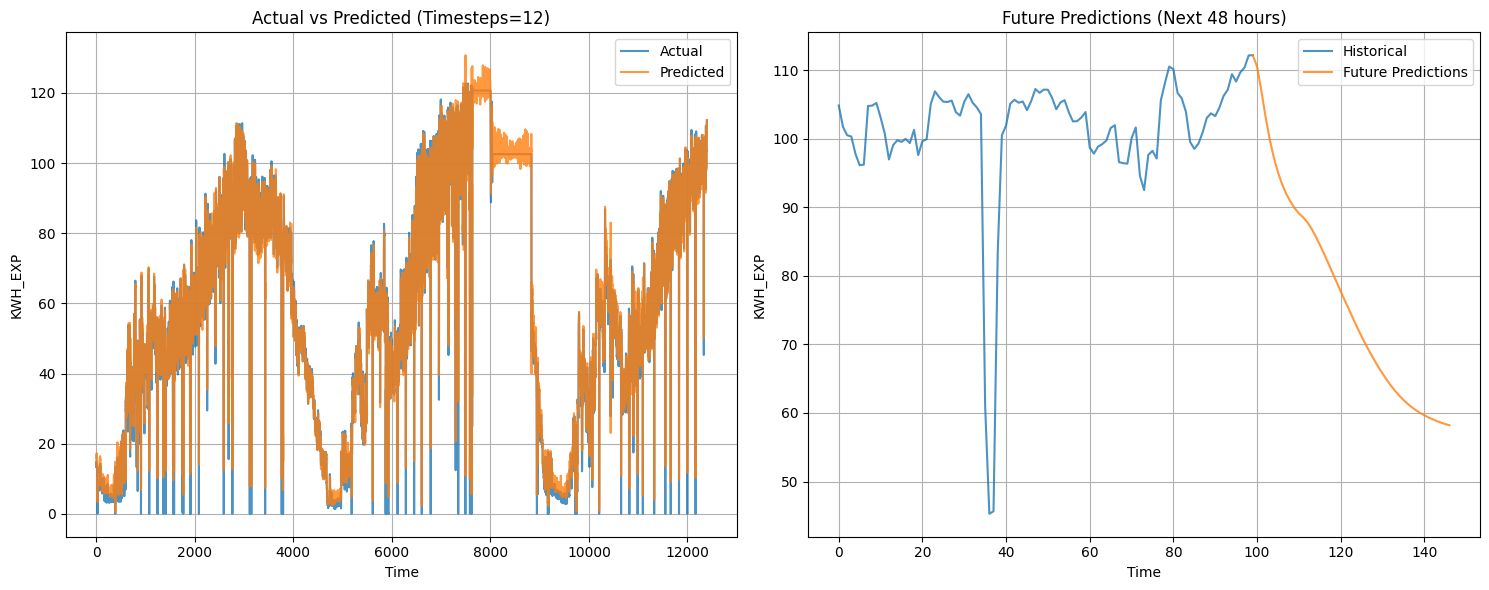


Metrics for timesteps=12:
MSE: 30.1296
R²: 0.9733
MAPE: 728228655492849.3750
MAE: 2.6843
Training time for timesteps = 12: 14.80 seconds

Training Bahdanau Attention Model with timesteps = 24
Epoch 19: early stopping
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━

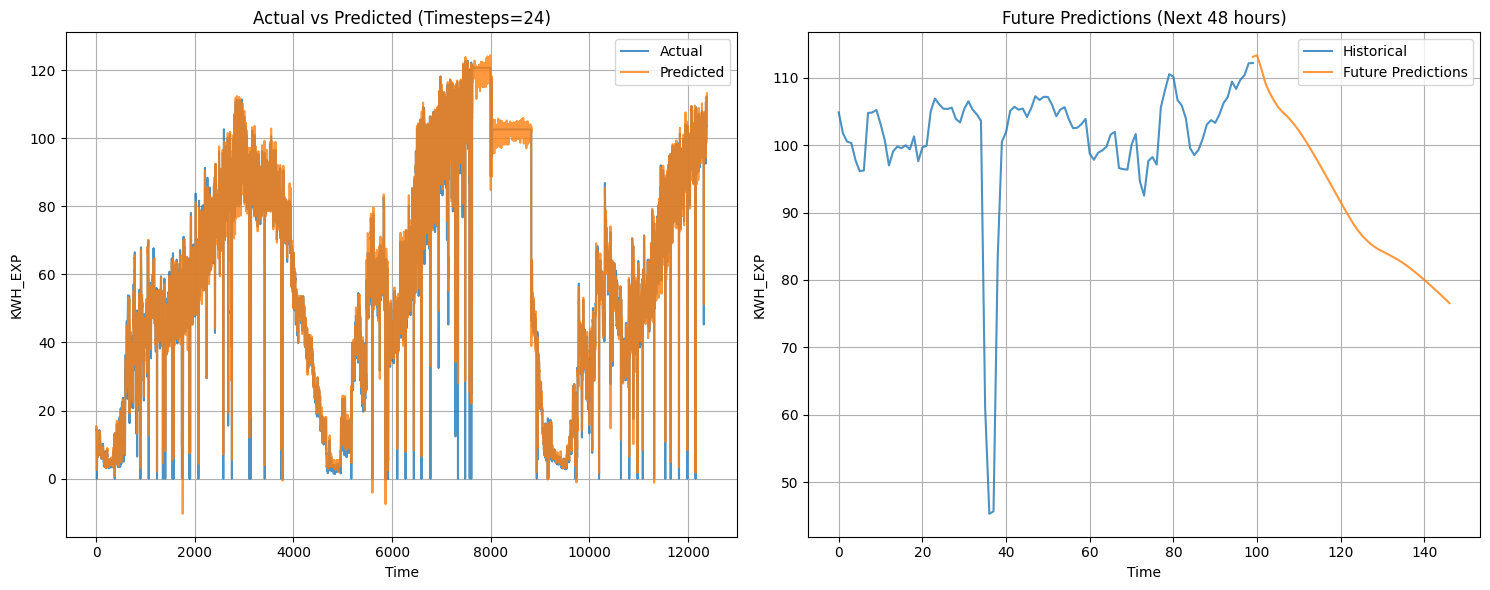


Metrics for timesteps=24:
MSE: 27.9246
R²: 0.9753
MAPE: 656388132181968.7500
MAE: 2.4492
Training time for timesteps = 24: 17.86 seconds

Training Bahdanau Attention Model with timesteps = 48
Epoch 14: early stopping
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━

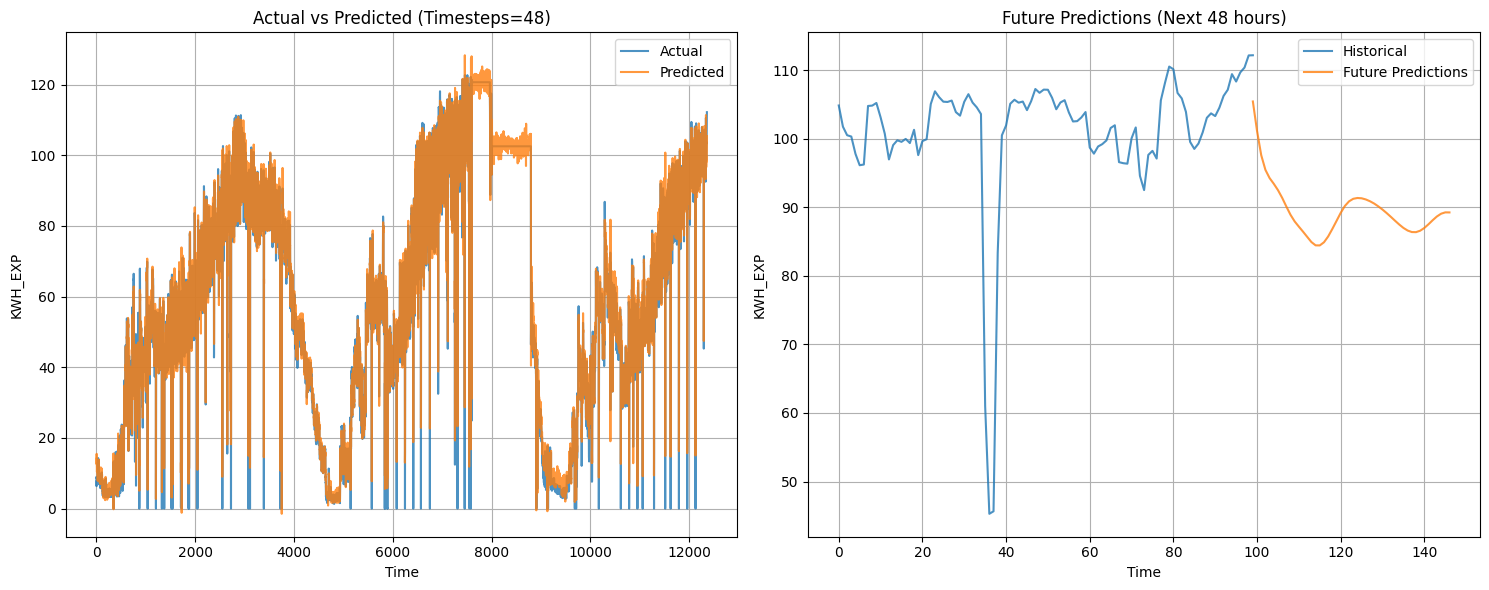


Metrics for timesteps=48:
MSE: 29.5446
R²: 0.9738
MAPE: 687205472917818.5000
MAE: 2.6429
Training time for timesteps = 48: 15.99 seconds

Training Bahdanau Attention Model with timesteps = 72
Epoch 11: early stopping
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━

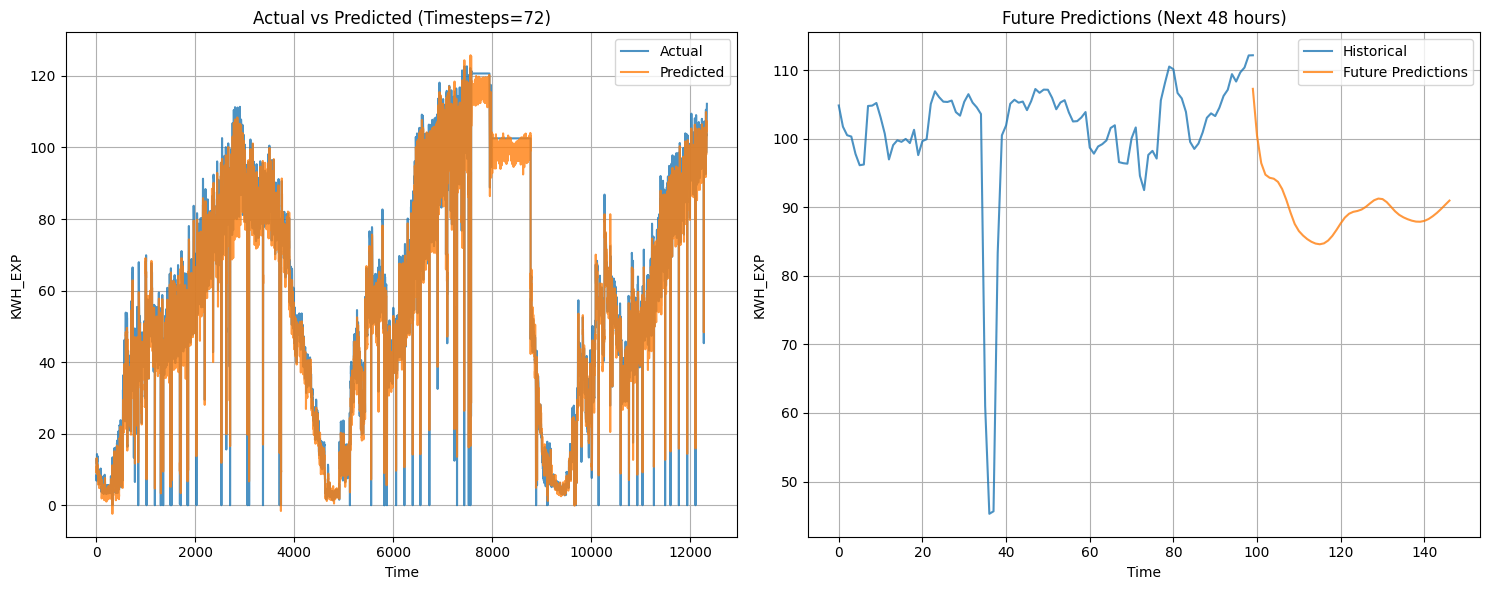


Metrics for timesteps=72:
MSE: 33.2896
R²: 0.9704
MAPE: 668878859828950.8750
MAE: 3.3928
Training time for timesteps = 72: 16.03 seconds

Training Bahdanau Attention Model with timesteps = 96
Epoch 14: early stopping
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━

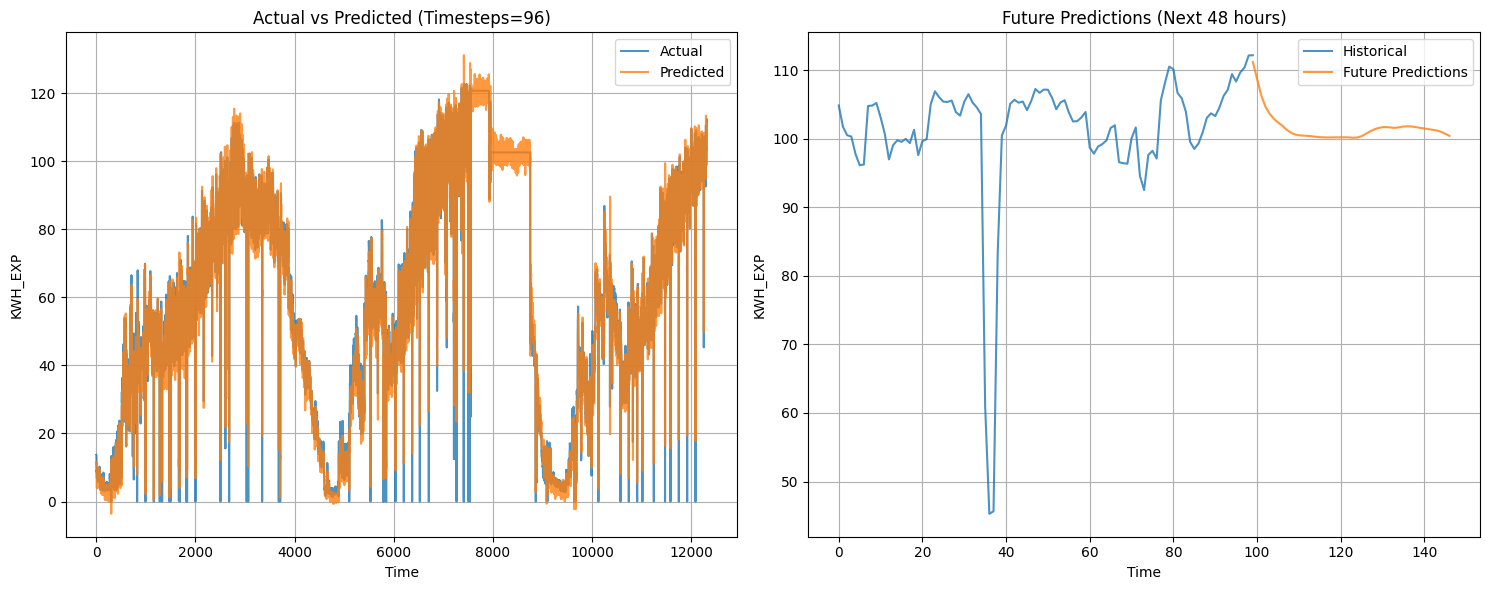


Metrics for timesteps=96:
MSE: 30.3192
R²: 0.9729
MAPE: 682368517502022.3750
MAE: 2.9326
Training time for timesteps = 96: 20.19 seconds

Training Bahdanau Attention Model with timesteps = 168
Epoch 9: early stopping
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━

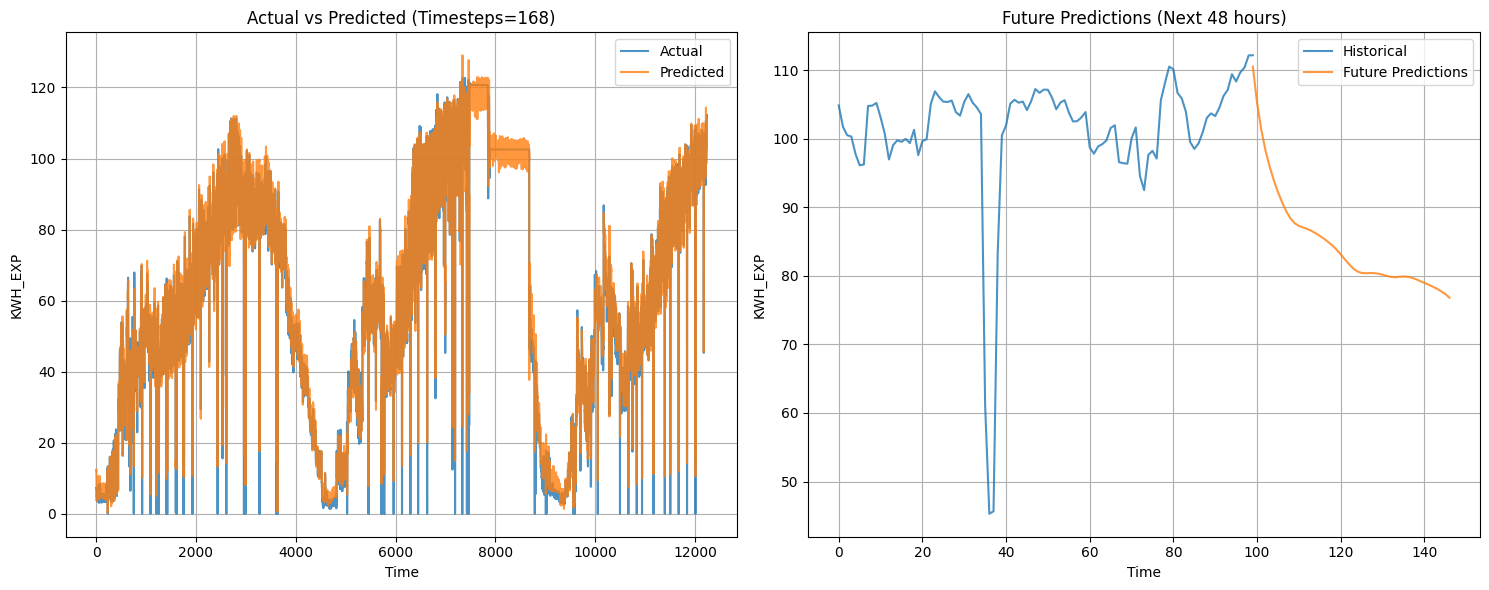


Metrics for timesteps=168:
MSE: 32.3945
R²: 0.9708
MAPE: 754013379865002.0000
MAE: 3.1118
Training time for timesteps = 168: 21.51 seconds


In [47]:
def train_and_plot_bahdanau_attention_model(X_train, y_train, X_test, y_test, timesteps):
    def create_dataset(X, y, time_steps=1):
        Xs, ys = [], []
        for i in range(len(X) - time_steps):
            v = X.iloc[i:(i + time_steps)].values
            Xs.append(v)
            ys.append(y[i + time_steps])
        return np.array(Xs), np.array(ys)

    X_train_t, y_train_t = create_dataset(X_train, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test, y_test, timesteps)

    lstm_units = 128
    attention_units = 64

    # Input layer
    inputs = tf.keras.Input(shape=(timesteps, X_train.shape[1]))

    # LSTM Layer
    lstm_output, final_hidden_state, _ = LSTM(
        lstm_units,
        return_sequences=True,
        return_state=True
    )(inputs)

    # Attention Layer
    attention_layer = BahdanauAttention(attention_units)
    context_vector, attention_weights = attention_layer(final_hidden_state, lstm_output)

    # Fully Connected Layers
    dense_output = Dense(64, activation='relu')(context_vector)
    output = Dense(1)(dense_output)

    # Define Model
    model = tf.keras.Model(inputs=inputs, outputs=output)

    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        mode='min',
        verbose=1
    )

    model.fit(
        X_train_t,
        y_train_t,
        validation_split=0.1,
        epochs=50,
        batch_size=512,
        callbacks=[early_stopping],
        verbose=0
    )

    plot_predictions(model, X_test_t, y_test_t, target_scaler, timesteps)

# Daftar timestep yang akan diuji
timesteps = [12, 24, 48, 72, 96, 168]  # 12 jam, 1 hari, 2 hari, 3 hari, 4 hari, 1 minggu

for ts in timesteps:
    start_time = time.time()
    print(f"\nTraining Bahdanau Attention Model with timesteps = {ts}")
    train_and_plot_bahdanau_attention_model(train_scaled_features, train_scaled_target.ravel(),
                                            test_scaled_features, test_scaled_target.ravel(), ts)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time for timesteps = {ts}: {training_time:.2f} seconds")


Training Bahdanau Attention Model with BiLSTM and timesteps = 12
Epoch 13: early stopping
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

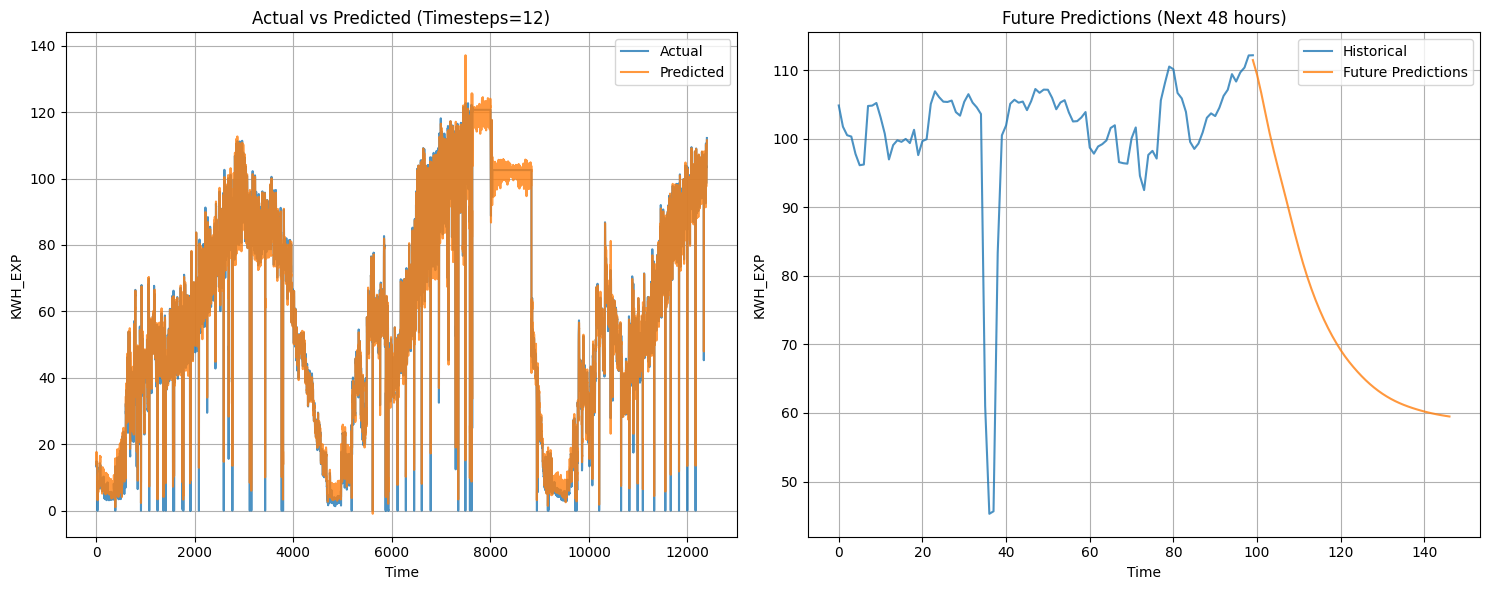


Metrics for timesteps=12:
MSE: 29.4103
R²: 0.9740
MAPE: 668551762506599.3750
MAE: 2.5853

Evaluation Metrics:
MSE: 29.4103
MAE: 2.5853
R²: 0.9740
MAPE: 668551762506599.3750%
Training time for timesteps = 12: 16.82 seconds

Training Bahdanau Attention Model with BiLSTM and timesteps = 24
Epoch 16: early stopping
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/

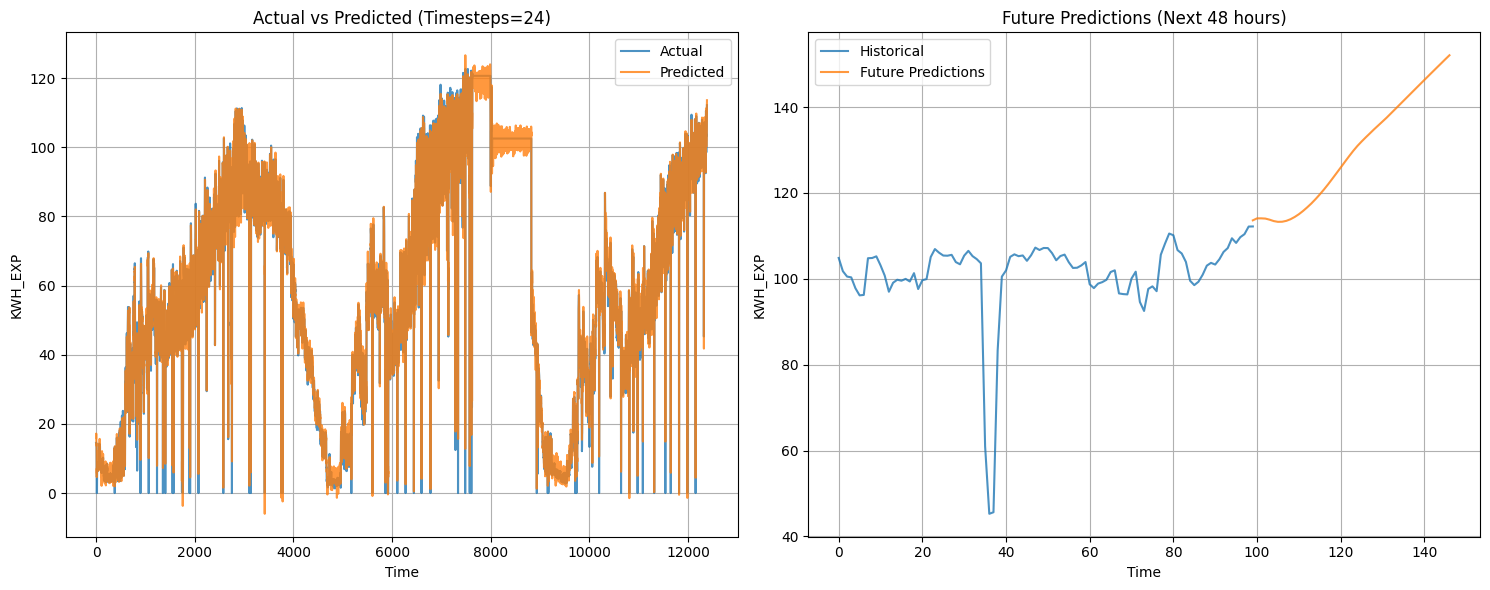


Metrics for timesteps=24:
MSE: 31.1890
R²: 0.9724
MAPE: 630791155750864.7500
MAE: 2.6537

Evaluation Metrics:
MSE: 31.1890
MAE: 2.6537
R²: 0.9724
MAPE: 630791155750864.7500%
Training time for timesteps = 24: 19.66 seconds

Training Bahdanau Attention Model with BiLSTM and timesteps = 48
Epoch 16: early stopping
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/s

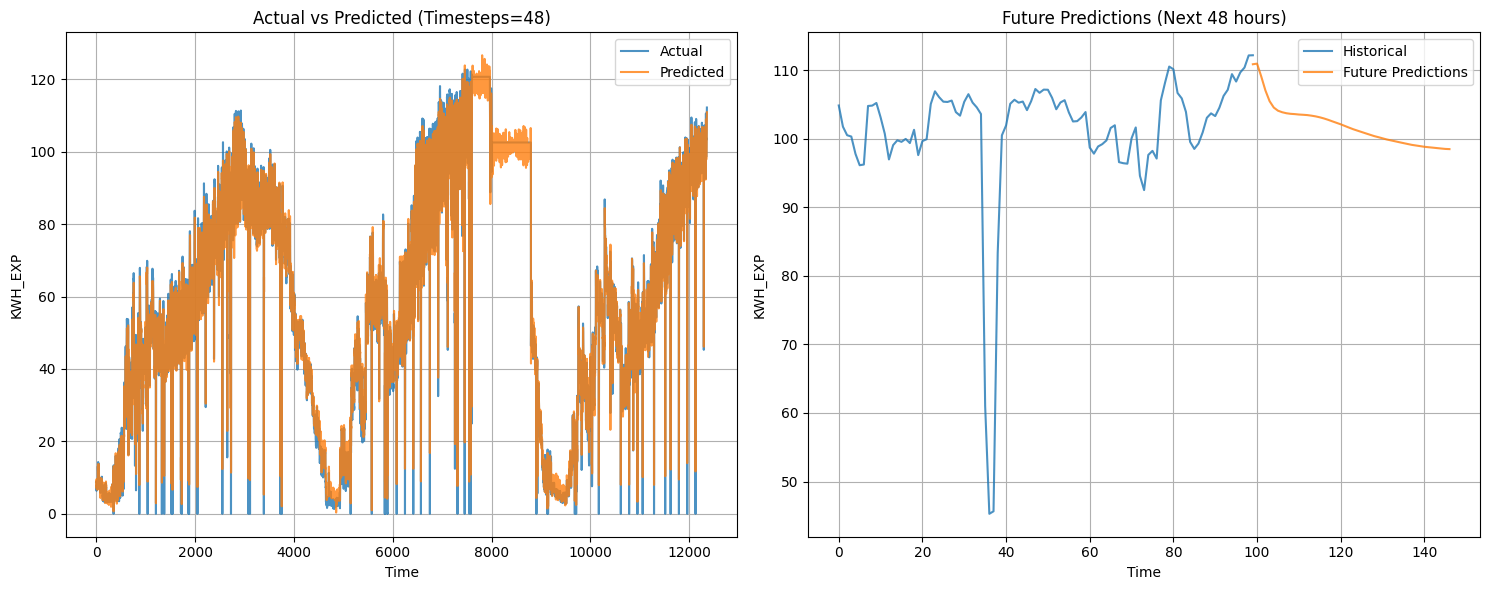


Metrics for timesteps=48:
MSE: 28.9784
R²: 0.9743
MAPE: 666976925945047.7500
MAE: 2.6386

Evaluation Metrics:
MSE: 28.9784
MAE: 2.6386
R²: 0.9743
MAPE: 666976925945047.7500%
Training time for timesteps = 48: 25.64 seconds

Training Bahdanau Attention Model with BiLSTM and timesteps = 72
Epoch 14: early stopping
386/386 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/s

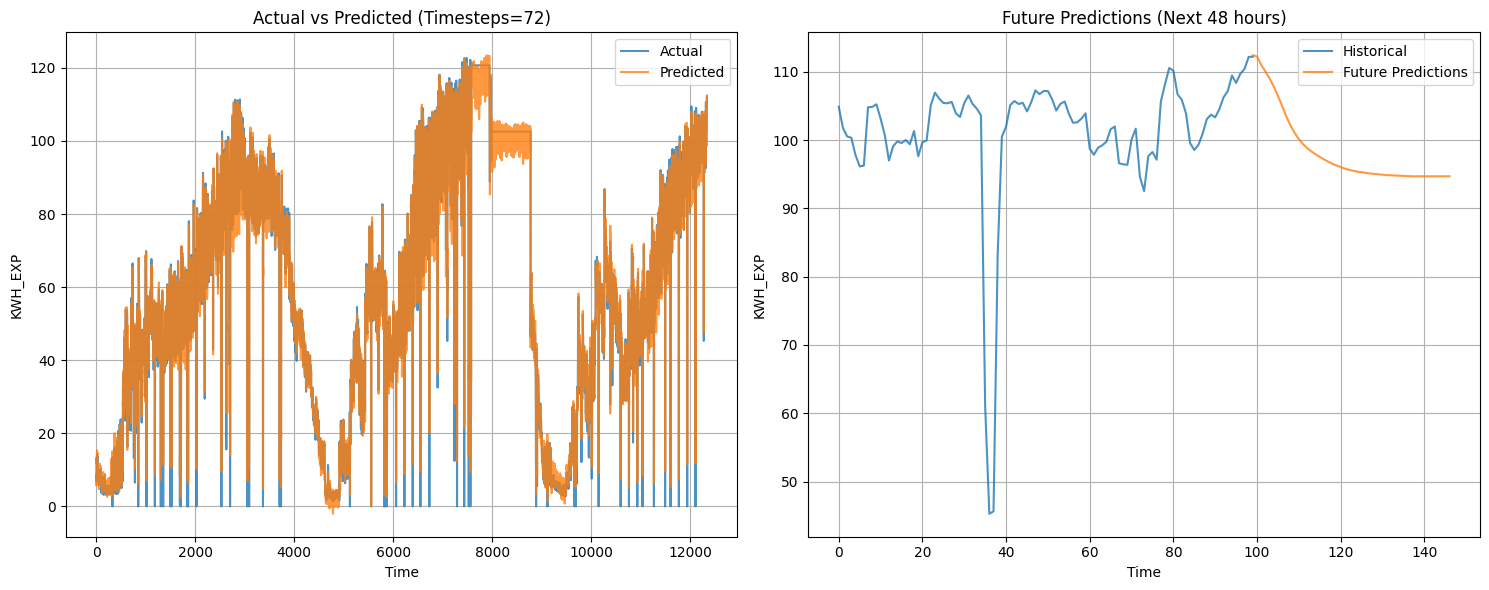


Metrics for timesteps=72:
MSE: 29.6785
R²: 0.9736
MAPE: 661588544856372.5000
MAE: 2.7753

Evaluation Metrics:
MSE: 29.6785
MAE: 2.7753
R²: 0.9736
MAPE: 661588544856372.5000%
Training time for timesteps = 72: 29.40 seconds

Training Bahdanau Attention Model with BiLSTM and timesteps = 96
Epoch 17: early stopping
385/385 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
385/385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/s

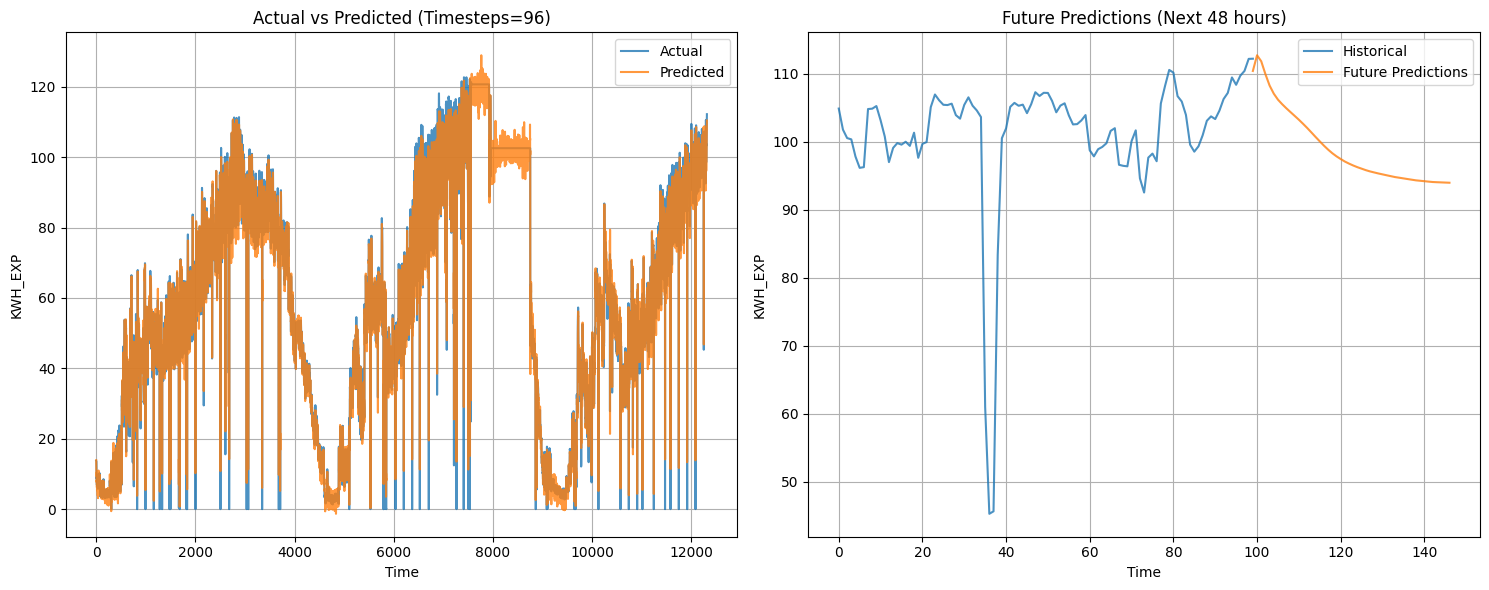


Metrics for timesteps=96:
MSE: 29.3898
R²: 0.9738
MAPE: 653960280968037.2500
MAE: 2.7788

Evaluation Metrics:
MSE: 29.3898
MAE: 2.7788
R²: 0.9738
MAPE: 653960280968037.2500%
Training time for timesteps = 96: 40.73 seconds

Training Bahdanau Attention Model with BiLSTM and timesteps = 168
Epoch 20: early stopping
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/

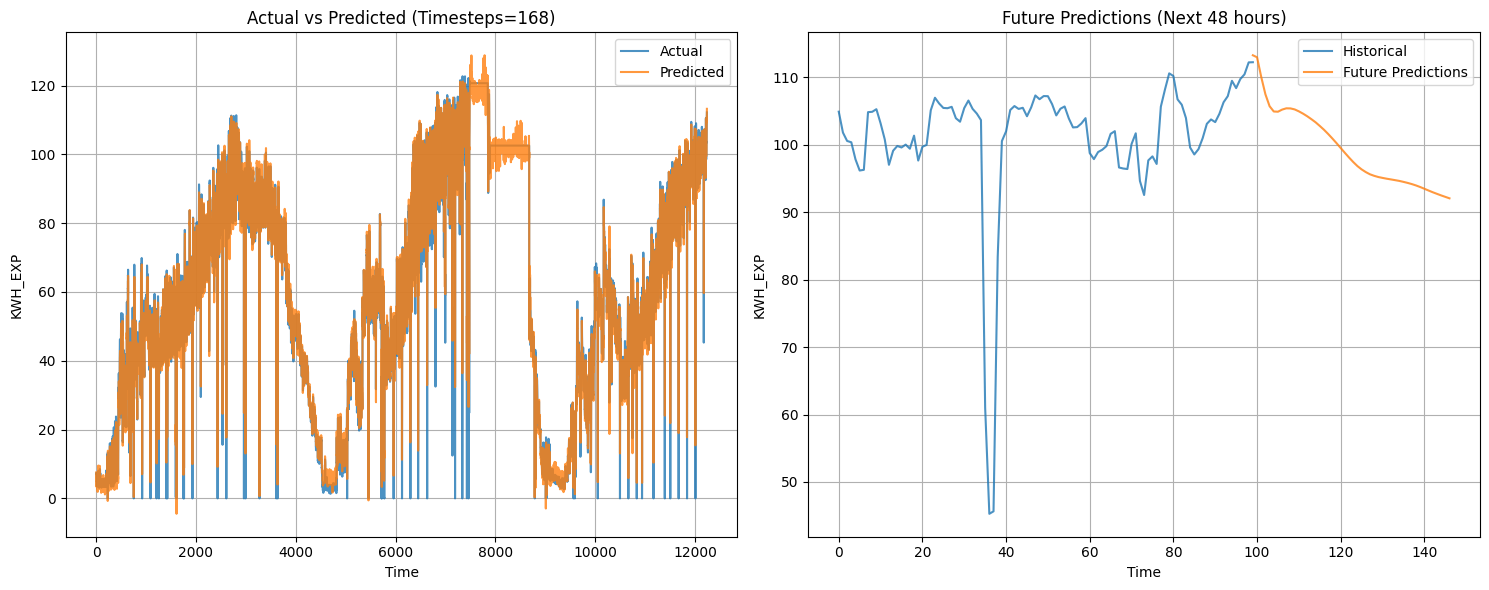


Metrics for timesteps=168:
MSE: 29.9982
R²: 0.9730
MAPE: 766992517006726.0000
MAE: 2.7385

Evaluation Metrics:
MSE: 29.9982
MAE: 2.7385
R²: 0.9730
MAPE: 766992517006726.0000%
Training time for timesteps = 168: 69.77 seconds


In [48]:

from tensorflow.keras.layers import Lambda
def evaluate_model(y_true, y_pred, scaler):
    # Inverse transform predictions and actual values
    y_true_orig = scaler.inverse_transform(y_true.reshape(-1, 1))
    y_pred_orig = scaler.inverse_transform(y_pred)

    # Calculate metrics
    mse = mean_squared_error(y_true_orig, y_pred_orig)
    mae = mean_absolute_error(y_true_orig, y_pred_orig)
    r2 = r2_score(y_true_orig, y_pred_orig)
    mape = mean_absolute_percentage_error(y_true_orig, y_pred_orig)

    print("\nEvaluation Metrics:")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.4f}%")

    return mse, mae, r2, mape

def train_and_plot_bahdanau_bilstm_model(X_train, y_train, X_test, y_test, timesteps):
    def create_dataset(X, y, time_steps=1):
        Xs, ys = [], []
        for i in range(len(X) - time_steps):
            v = X.iloc[i:(i + time_steps)].values
            Xs.append(v)
            ys.append(y[i + time_steps])
        return np.array(Xs), np.array(ys)

    X_train_t, y_train_t = create_dataset(X_train, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test, y_test, timesteps)

    lstm_units = 128
    attention_units = 64

    # Input layer
    inputs = tf.keras.Input(shape=(timesteps, X_train.shape[1]))

    # BiLSTM Layer
    bilstm_output = tf.keras.layers.Bidirectional(
        LSTM(lstm_units, return_sequences=True, return_state=False)
    )(inputs)

    # Attention Layer with corrected reduce_mean
    mean_output = Lambda(lambda x: tf.reduce_mean(x, axis=1))(bilstm_output)
    attention_layer = BahdanauAttention(attention_units)
    context_vector, attention_weights = attention_layer(mean_output, bilstm_output)

    # Fully Connected Layers
    dense_output = Dense(64, activation='relu')(context_vector)
    output = Dense(1)(dense_output)

    # Define Model
    model = tf.keras.Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        mode='min',
        verbose=1
    )

    model.fit(
        X_train_t,
        y_train_t,
        validation_split=0.1,
        epochs=50,
        batch_size=512,
        callbacks=[early_stopping],
        verbose=0
    )

    # Predictions
    y_pred = model.predict(X_test_t)
    plot_predictions(model, X_test_t, y_test_t, target_scaler, timesteps)

    # Evaluate model
    evaluate_model(y_test_t, y_pred, target_scaler)

# Daftar timestep yang akan diuji
timesteps = [12, 24, 48, 72, 96, 168]  # 12 jam, 1 hari, 2 hari, 3 hari, 4 hari, 1 minggu

for ts in timesteps:
    start_time = time.time()
    print(f"\nTraining Bahdanau Attention Model with BiLSTM and timesteps = {ts}")
    train_and_plot_bahdanau_bilstm_model(train_scaled_features, train_scaled_target.ravel(),
                                         test_scaled_features, test_scaled_target.ravel(), ts)

    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time for timesteps = {ts}: {training_time:.2f} seconds")